# Project Overview

The U.S. Department of Education publishes a College Scorecard dataset each academic year. In the 2017-18 school year, the dataset contained almost 2,000 columns for more than 7,000 schools across the country. Information includes school location, size, demographics, finances, graduation rates, student debt, student mortality, and more.

My project will seek to classify schools where median student debt is above \\$10,000. This research and model may be useful to prospective students, educators, college officials, and other stakeholders interested in education and financial policies.

*For this project, I'll consider p-values significant if they are greater than 0.05.*

# Installing libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import normaltest
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Importing data

In [2]:
college_df = pd.read_csv('/Users/ellenpaigehoffman/Desktop/College_Scorecard_2017_18.csv')

In [3]:
college_df.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOTFIRSTTIME_POOLED_SUPP,OMENRUP_NOTFIRSTTIME_POOLED_SUPP,OMENRYP_FULLTIME_POOLED_SUPP,OMENRAP_FULLTIME_POOLED_SUPP,OMAWDP8_FULLTIME_POOLED_SUPP,OMENRUP_FULLTIME_POOLED_SUPP,OMENRYP_PARTTIME_POOLED_SUPP,OMENRAP_PARTTIME_POOLED_SUPP,OMAWDP8_PARTTIME_POOLED_SUPP,OMENRUP_PARTTIME_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,https://galileo.aamu.edu/NetPriceCalculator/np...,...,0.4048,0.2645,0.0137,0.315,0.3755,0.2958,0.0289,0.4224,0.2635,0.2852
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,...,0.5448,0.12,0.0728,0.2583,0.5872,0.0817,0.1398,0.2618,0.3977,0.2008
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,0.4647,0.1912,0.0148,0.3284,0.4391,0.2177,0.028,0.3645,0.4486,0.1589
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.5121,0.1593,0.0165,0.323,0.5361,0.1243,0.0245,0.3947,0.3476,0.2331
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.4226,0.0754,0.0254,0.5327,0.3133,0.1286,0.021,0.5804,0.1678,0.2308


In [3]:
print('Shape of the College Scorecard dataset: {}'.format(college_df.shape))

Shape of the College Scorecard dataset: (7112, 1977)


In [3]:
# preserving original df
source_df = college_df.copy()

## Looking for nulls
As there are almost 2,000 columns, I'd like to see if any have a lot of nulls before I continue. This will help me identify more useful features.

In [6]:
null_count = college_df.isna().sum().sort_values(ascending=False)
print(null_count)

COMP_ORIG_YR6_RT                7112
FIRSTGEN_ENRL_ORIG_YR4_RT       7112
NOLOAN_UNKN_4YR_TRANS_YR4_RT    7112
NOLOAN_UNKN_2YR_TRANS_YR4_RT    7112
FIRSTGEN_DEATH_YR4_RT           7112
                                ... 
REGION                             0
HSI                                0
ICLEVEL                            0
OPEFLAG                            0
UNITID                             0
Length: 1977, dtype: int64


In [7]:
print("Number of columns over 80% null: {}".format((null_count > (7112*.80)).sum()))

Number of columns over 80% null: 1370


In [7]:
print("Number of columns over 90% null: {}".format((null_count > (7112*.9)).sum()))

Number of columns over 90% null: 1336


In [9]:
print("Number of columns 100% null: {}".format((null_count > (7112)).sum()))

Number of columns 100% null: 0


In [4]:
# dropping 1336 cols that are over 90% null
thresh = len(college_df) * .1
college_df.dropna(thresh = thresh, axis = 1, inplace = True)

In [5]:
print('Shape of the dataset: {}'.format(college_df.shape))

Shape of the dataset: (7112, 641)


## Removing colleges that are not currently operating
CURROPER is a binary flag, where 0 indicates the school is not currently certified as an operating institution.

In [10]:
college_df.CURROPER.value_counts()

1    6505
0     607
Name: CURROPER, dtype: int64

In [6]:
print('Percent of schools NOT currently operating: {}%'.format(round(607/7112*100)))

Percent of schools NOT currently operating: 9%


In [7]:
# dropping 607 schools that are not operating
college_df = college_df[college_df.CURROPER == 1]

In [8]:
# reseting index
college_df = college_df.reset_index(drop=True)

In [9]:
print('Shape of the dataset: {}'.format(college_df.shape))

Shape of the dataset: (6505, 641)


# Exploratory Data Analysis

In [17]:
college_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Columns: 641 entries, UNITID to OMENRUP_PARTTIME_POOLED_SUPP
dtypes: float64(527), int64(14), object(100)
memory usage: 31.8+ MB


In [18]:
college_df.columns.to_series().groupby(college_df.dtypes).groups

{dtype('int64'): Index(['UNITID', 'OPEID', 'OPEID6', 'HCM2', 'MAIN', 'NUMBRANCH', 'PREDDEG',
        'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'CURROPER', 'ICLEVEL',
        'OPEFLAG'],
       dtype='object'),
 dtype('float64'): Index(['LOCALE', 'LATITUDE', 'LONGITUDE', 'CCBASIC', 'CCUGPROF', 'CCSIZSET',
        'HBCU', 'PBI', 'ANNHI', 'TRIBAL',
        ...
        'OMAWDP8_NOTFIRSTTIME', 'OMENRUP_NOTFIRSTTIME', 'OMENRYP_FULLTIME',
        'OMENRAP_FULLTIME', 'OMAWDP8_FULLTIME', 'OMENRUP_FULLTIME',
        'OMENRYP_PARTTIME', 'OMENRAP_PARTTIME', 'OMAWDP8_PARTTIME',
        'OMENRUP_PARTTIME'],
       dtype='object', length=527),
 dtype('O'): Index(['INSTNM', 'CITY', 'STABBR', 'ZIP', 'ACCREDAGENCY', 'INSTURL', 'NPCURL',
        'HSI', 'DEBT_MDN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN', 'LO_INC_DEBT_MDN',
        'MD_INC_DEBT_MDN', 'HI_INC_DEBT_MDN', 'DEP_DEBT_MDN', 'IND_DEBT_MDN',
        'PELL_DEBT_MDN', 'NOPELL_DEBT_MDN', 'FEMALE_DEBT_MDN', 'MALE_DEBT_MDN',
        'FIRSTGEN_DEBT_MDN', 'N

In [19]:
college_df.describe().round(2)

,UNITID,OPEID,OPEID6,HCM2,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,ST_FIPS,...,OMAWDP8_NOTFIRSTTIME,OMENRUP_NOTFIRSTTIME,OMENRYP_FULLTIME,OMENRAP_FULLTIME,OMAWDP8_FULLTIME,OMENRUP_FULLTIME,OMENRYP_PARTTIME,OMENRAP_PARTTIME,OMAWDP8_PARTTIME,OMENRUP_PARTTIME
count,6505.00,6505.00,6505.00,6505.00,6505.0,6505.00,6505.00,6505.00,6505.00,6505.00,...,3564.00,3564.00,3658.00,3658.00,3658.00,3658.00,3068.00,3068.00,3068.00,3068.00
mean,1775012.97,1729789.43,16175.66,0.01,0.8,3.39,1.87,2.27,2.07,29.17,...,0.51,0.29,0.01,0.19,0.52,0.28,0.02,0.21,0.35,0.42
std,6768907.58,2810322.14,14628.72,0.10,0.4,8.56,1.06,1.35,0.83,16.75,...,0.23,0.20,0.03,0.15,0.21,0.19,0.06,0.17,0.22,0.23
min,100654.00,100200.00,1002.00,0.00,0.0,1.00,0.00,0.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,171395.00,306600.00,3051.00,0.00,1.0,1.00,1.00,1.00,1.00,13.00,...,0.33,0.14,0.00,0.05,0.35,0.12,0.00,0.05,0.18,0.25
50%,222886.00,991000.00,9896.00,0.00,1.0,1.00,2.00,2.00,2.00,29.00,...,0.51,0.26,0.00,0.20,0.50,0.26,0.01,0.22,0.31,0.41
75%,448220.00,3000100.00,26127.00,0.00,1.0,2.00,3.00,4.00,3.00,42.00,...,0.68,0.39,0.01,0.29,0.67,0.40,0.02,0.32,0.49,0.56
max,49005401.00,82098842.00,42698.00,1.00,1.0,73.00,4.00,4.00,3.00,78.00,...,1.00,1.00,0.68,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Target: Median Debt
DEBT_MDN is the median original amount of the loan principal upon entering repayment.

In [20]:
college_df.DEBT_MDN.value_counts()

PrivacySuppressed    906
9500                 519
5500                 252
6333                 135
12000                113
                    ... 
9417                   1
13889                  1
4313                   1
5467                   1
8071                   1
Name: DEBT_MDN, Length: 1835, dtype: int64

In [10]:
# Replacing values that are suppressed due to privacy with null
college_df.DEBT_MDN.replace('PrivacySuppressed', np.nan, inplace=True)

In [11]:
# Updating data type to float
college_df.DEBT_MDN = college_df.DEBT_MDN.astype(float)

In [12]:
college_df.DEBT_MDN.isna().sum()

1035

In [13]:
print('DEBT_MDN is about {}% null.'.format(round((1035/6505)*100)))

DEBT_MDN is about 16% null.


In [33]:
college_df.DEBT_MDN.describe().round(2)

count     5470.0
mean     11394.4
std       5339.0
min       1510.0
25%       7164.0
50%       9500.0
75%      15000.0
max      38999.0
Name: DEBT_MDN, dtype: float64

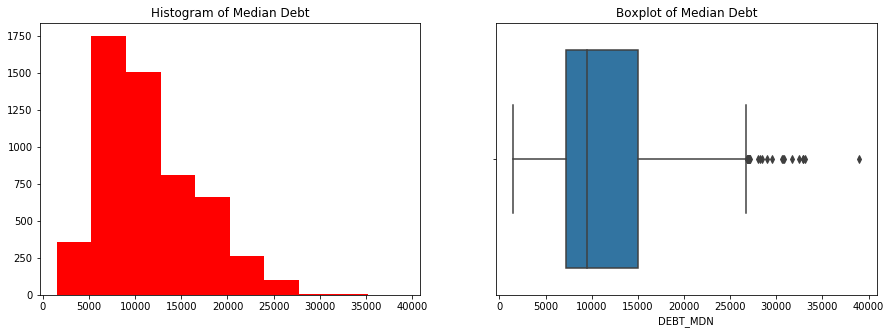

In [26]:
# plotting distribution

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.title('Histogram of Median Debt')
plt.hist(college_df.DEBT_MDN, color='r')

plt.subplot(1,2,2)
plt.title('Boxplot of Median Debt')
sns.boxplot(college_df.DEBT_MDN);

**Observations:**
- Average median debt is \\$11,394.40
- The minimum is \\$1,510.00 and maximum is \\$38,999.00.
- The distribution skews right. There are upper outliers, which I'll explore further below.

### Outlier analysis

In [27]:
q75, q25 = np.nanpercentile(college_df.DEBT_MDN, [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((college_df.DEBT_MDN > max_val) 
                      | (college_df.DEBT_MDN < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 175
The score threshold is: 1.5
Number of outliers is: 33
The score threshold is: 2.0
Number of outliers is: 8
The score threshold is: 2.5
Number of outliers is: 1
The score threshold is: 3.0
Number of outliers is: 1
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [28]:
print('Percent of data at threshold 1: {}%'.format(round(175/6505*100)))
print('Percent of data at threshold 1.5: {}%'.format(round(33/6505*100)))
print('Percent of data at threshold 2: {}%'.format(round(8/6505*100)))

Percent of data at threshold 1: 3%
Percent of data at threshold 1.5: 1%
Percent of data at threshold 2: 0%


In [29]:
print(np.where(college_df.DEBT_MDN > (q75+iqr*2.5)))

(array([4673]),)


In [30]:
college_df.loc[[4673]]

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOTFIRSTTIME_POOLED_SUPP,OMENRUP_NOTFIRSTTIME_POOLED_SUPP,OMENRYP_FULLTIME_POOLED_SUPP,OMENRAP_FULLTIME_POOLED_SUPP,OMAWDP8_FULLTIME_POOLED_SUPP,OMENRUP_FULLTIME_POOLED_SUPP,OMENRYP_PARTTIME_POOLED_SUPP,OMENRAP_PARTTIME_POOLED_SUPP,OMAWDP8_PARTTIME_POOLED_SUPP,OMENRUP_PARTTIME_POOLED_SUPP
4673,442949,3668300,36683,Birthingway College of Midwifery,Portland,OR,97266,Midwifery Education Accreditation Council,birthingway.edu,birthingway.edu/about-us/consumer-information/...,...,0.4333,0.4667,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed


The most extreme outlier is a Midwifery college in Portland, where median debt is \\$38,999. As visualized in the boxplot above, this is significantly higher than other schools. I'll drop this row now, so it doesn't impact the rest of my exploration and modeling.

In [14]:
# dropping 1 outlier
college_df = college_df.drop([4673], axis=0)

In [15]:
# reseting index
college_df = college_df.reset_index(drop=True)

In [16]:
print('Shape of the dataset: {}'.format(college_df.shape))

Shape of the dataset: (6504, 641)


In [34]:
college_df.DEBT_MDN.describe().round(2)

count     5469.00
mean     11389.35
std       5326.42
min       1510.00
25%       7161.00
50%       9500.00
75%      15000.00
max      33166.00
Name: DEBT_MDN, dtype: float64

**Observations:**
- After dropping the most extreme point, average median debt is \\$11,389.35 and maximum is \\$33,166.00. 
- There are still upper outliers, which I will need to consider when I implement a model.

## Features

In [35]:
print(college_df.columns[0:100])
print(college_df.columns[100:200])
print(college_df.columns[200:300])
print(college_df.columns[300:400])
print(college_df.columns[400:500])
print(college_df.columns[500:600])
print(college_df.columns[600:642])

Index(['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP',
       'ACCREDAGENCY', 'INSTURL', 'NPCURL', 'HCM2', 'MAIN', 'NUMBRANCH',
       'PREDDEG', 'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE',
       'LATITUDE', 'LONGITUDE', 'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'HBCU',
       'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'MENONLY',
       'WOMENONLY', 'RELAFFIL', 'ADM_RATE', 'ADM_RATE_ALL', 'SATVR25',
       'SATVR75', 'SATMT25', 'SATMT75', 'SATVRMID', 'SATMTMID', 'ACTCM25',
       'ACTCM75', 'ACTEN25', 'ACTEN75', 'ACTMT25', 'ACTMT75', 'ACTCMMID',
       'ACTENMID', 'ACTMTMID', 'SAT_AVG', 'SAT_AVG_ALL', 'PCIP01', 'PCIP03',
       'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11', 'PCIP12', 'PCIP13',
       'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24',
       'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP38',
       'PCIP39', 'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45',
       'PCIP46', 'PCIP47', 'PCIP48

### Predominant and highest degrees awarded
These are ordinal categories ranging from 0- non-degree granting, to 4- graduate degree.

In [36]:
college_df[['PREDDEG', 'HIGHDEG']].isna().sum()

PREDDEG    0
HIGHDEG    0
dtype: int64

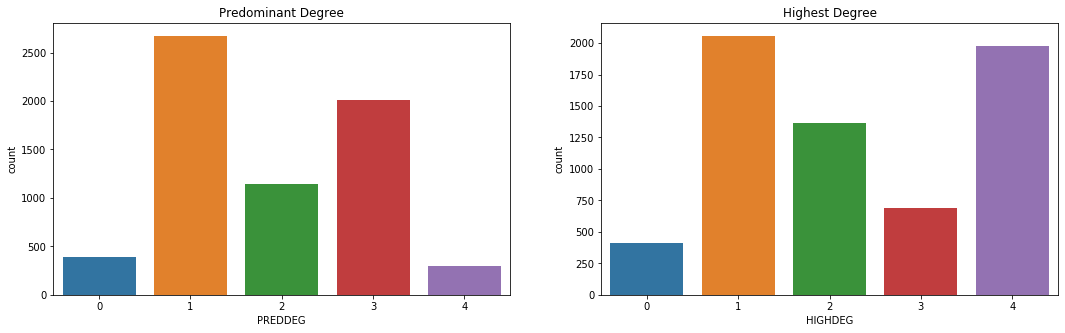

In [37]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.countplot(x='PREDDEG', data=college_df)
plt.title('Predominant Degree')

plt.subplot(1,2,2)
sns.countplot(x='HIGHDEG', data=college_df)
plt.title('Highest Degree');

In [41]:
college_df.HIGHDEG.value_counts()

1    2057
4    1977
2    1366
3     690
0     414
Name: HIGHDEG, dtype: int64

In [38]:
pearsonr(college_df.PREDDEG, college_df.HIGHDEG)

(0.9115146719082721, 0.0)

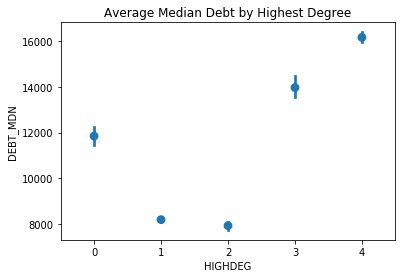

In [39]:
sns.pointplot(x= 'HIGHDEG', y='DEBT_MDN', data=college_df, join=False)
plt.title('Average Median Debt by Highest Degree');

In [38]:
college_df.groupby('HIGHDEG')['DEBT_MDN'].mean().round()

HIGHDEG
0    11850.0
1     8201.0
2     7938.0
3    13969.0
4    16162.0
Name: DEBT_MDN, dtype: float64

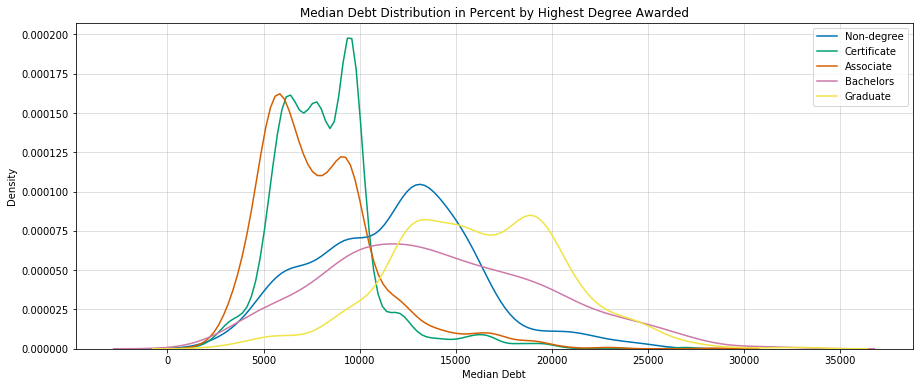

In [40]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(college_df.loc[college_df['HIGHDEG'] == 0, 'DEBT_MDN'], label = 'Non-degree')
sns.kdeplot(college_df.loc[college_df['HIGHDEG'] == 1, 'DEBT_MDN'], label = 'Certificate')
sns.kdeplot(college_df.loc[college_df['HIGHDEG'] == 2, 'DEBT_MDN'], label = 'Associate')
sns.kdeplot(college_df.loc[college_df['HIGHDEG'] == 3, 'DEBT_MDN'], label = 'Bachelors')
sns.kdeplot(college_df.loc[college_df['HIGHDEG'] == 4, 'DEBT_MDN'], label = 'Graduate')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Median Debt Distribution in Percent by Highest Degree Awarded');

**Observations:**
- Certificate is the most common category in both variables.
- These variables have a high positive correlation.
- Average median debt is highest at schools where a graduate degree is the highest offered and lowest where an associate degree is the highest offered.
- There is a high concentration of certificate and associate-granting schools where median debt is between \\$5,000-\\$10,000. Other categories are more widely distributed, with more occurrences of higher debt.

### Control
Control is a categorical variable signifying ownership: 1-public, 2-private nonprofit, and 3-private for-profit.

In [45]:
college_df['CONTROL'].isna().sum()

0

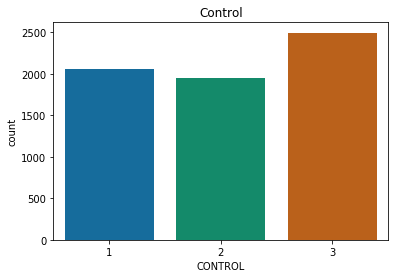

In [46]:
sns.countplot(x='CONTROL', data=college_df)
plt.title('Control');

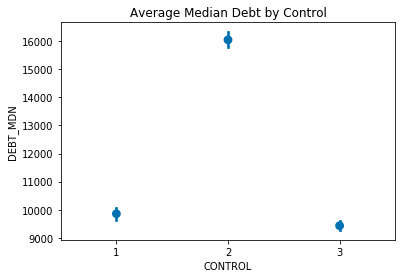

In [130]:
sns.pointplot(x= 'CONTROL', y='DEBT_MDN', data=college_df, join=False)
plt.title('Average Median Debt by Control');

In [47]:
college_df.groupby('CONTROL')['DEBT_MDN'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
CONTROL,,,,,,,,
1,1733.0,9857.70,4747.73,2016.0,5822.0,8427.0,13750.0,27000.0
2,1507.0,16044.74,5232.66,1510.0,12467.5,16370.0,19500.0,33166.0
3,2229.0,9432.73,3644.66,1974.0,7042.0,9498.0,10556.0,32875.0


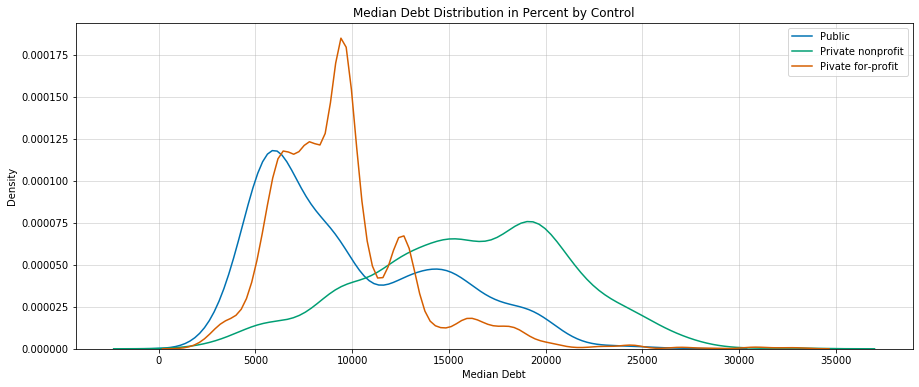

In [132]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(college_df.loc[college_df['CONTROL'] == 1, 'DEBT_MDN'], label = 'Public')
sns.kdeplot(college_df.loc[college_df['CONTROL'] == 2, 'DEBT_MDN'], label = 'Private nonprofit')
sns.kdeplot(college_df.loc[college_df['CONTROL'] == 3, 'DEBT_MDN'], label = 'Pivate for-profit')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Median Debt Distribution in Percent by Control');

In [22]:
# examples of private nonprofits
college_df[college_df['CONTROL'] == 2][['INSTNM','CITY','STABBR',
                                        'HIGHDEG','DEBT_MDN']].sort_values(by='HIGHDEG')

,INSTNM,CITY,STABBR,HIGHDEG,DEBT_MDN
6490,Relay Graduate School of Education - Washingto...,Washington,DC,0,NaN
6244,Davenport University-Holland Location,Holland,MI,0,16500.0
6243,Davenport University-Midland Location,Midland,MI,0,16500.0
6242,Davenport University-Lansing Location,Lansing,MI,0,16500.0
6241,Davenport University-Kalamazoo Location,Kalamazoo,MI,0,16500.0
...,...,...,...,...,...
1942,Sierra Nevada College,Incline Village,NV,4,15000.0
1933,York College,York,NE,4,14125.0
1929,Union College,Lincoln,NE,4,19500.0
1988,Centenary University,Hackettstown,NJ,4,19326.0


**Observations:**
- There are about 1,500 private nonprofits, 1,700 public, and 2,200 private for-profit schools in the dataset.
- Average median debt is significantly higher at private nonprofit schools.
- There is a high concentration of median debt near \\$10,000 at private for-profit schools; and between \\$5,000-\\$10,000 at public schools. Private nonprofits have a wider distribution, with most points between \\$5,000 and \\$25,000.

### Region
This is a categorical variable signifying 10 regions in the U.S.

In [48]:
college_df['REGION'].isna().sum()

0

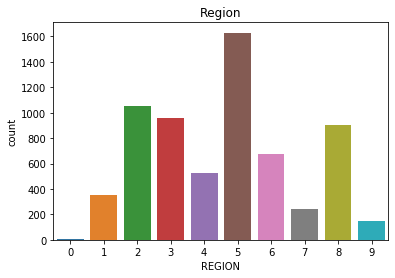

In [33]:
sns.countplot(x="REGION", data=college_df)
plt.title('Region');

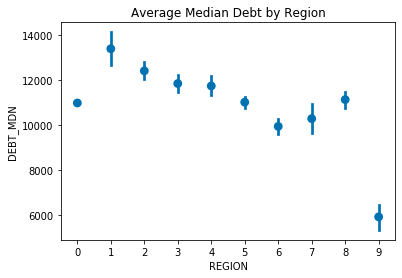

In [50]:
sns.pointplot(x= 'REGION', y='DEBT_MDN', data=college_df, join=False)
plt.title('Average Median Debt by Region');

In [51]:
college_df.groupby('REGION')['DEBT_MDN'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
REGION,,,,,,,,
0,1.0,10983.00,NaN,10983.0,10983.00,10983.0,10983.00,10983.0
1,319.0,13386.48,6494.26,3500.0,8027.50,12000.0,18963.00,33166.0
2,893.0,12407.90,5887.29,1510.0,7664.00,10563.0,17838.00,27000.0
3,855.0,11845.66,5594.89,2250.0,7307.00,9750.0,16062.50,29500.0
4,473.0,11739.14,4647.90,3500.0,8173.00,10923.0,15000.00,25250.0
5,1328.0,11019.36,4799.54,1974.0,7029.00,9501.0,14250.00,28000.0
6,552.0,9945.55,4269.95,2334.0,6657.25,9500.0,12667.00,32875.0
7,209.0,10288.26,4732.10,3500.0,6650.00,9246.0,12813.00,31750.0
8,768.0,11133.91,5352.38,2500.0,6986.75,9500.0,14638.25,32429.0


In [52]:
college_df.groupby('REGION')['DEBT_MDN'].mean().sort_values()

REGION
9     5935.929577
6     9945.550725
7    10288.258373
0    10983.000000
5    11019.361446
8    11133.910156
4    11739.141649
3    11845.659649
2    12407.896976
1    13386.479624
Name: DEBT_MDN, dtype: float64

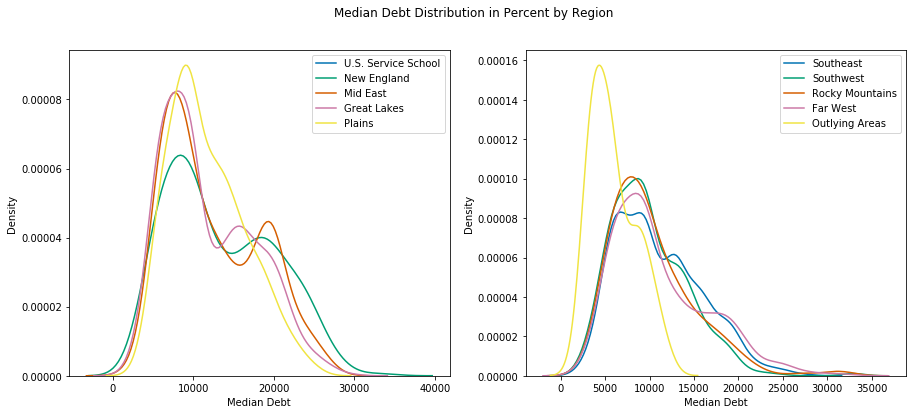

In [135]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
plt.suptitle('Median Debt Distribution in Percent by Region')

plt.subplot(1,2,1)
sns.kdeplot(college_df.loc[college_df['REGION'] == 0, 'DEBT_MDN'], label = 'U.S. Service School')
sns.kdeplot(college_df.loc[college_df['REGION'] == 1, 'DEBT_MDN'], label = 'New England')
sns.kdeplot(college_df.loc[college_df['REGION'] == 2, 'DEBT_MDN'], label = 'Mid East')
sns.kdeplot(college_df.loc[college_df['REGION'] == 3, 'DEBT_MDN'], label = 'Great Lakes')
sns.kdeplot(college_df.loc[college_df['REGION'] == 4, 'DEBT_MDN'], label = 'Plains')
plt.xlabel('Median Debt')
plt.ylabel('Density')

plt.subplot(1,2,2)
sns.kdeplot(college_df.loc[college_df['REGION'] == 5, 'DEBT_MDN'], label = 'Southeast')
sns.kdeplot(college_df.loc[college_df['REGION'] == 6, 'DEBT_MDN'], label = 'Southwest')
sns.kdeplot(college_df.loc[college_df['REGION'] == 7, 'DEBT_MDN'], label = 'Rocky Mountains')
sns.kdeplot(college_df.loc[college_df['REGION'] == 8, 'DEBT_MDN'], label = 'Far West')
sns.kdeplot(college_df.loc[college_df['REGION'] == 9, 'DEBT_MDN'], label = 'Outlying Areas')
plt.xlabel('Median Debt')
plt.ylabel('Density');

In [34]:
# examples of outlying areas:
college_df[college_df.REGION == 9][['INSTNM','CITY','STABBR','DEBT_MDN']]

,INSTNM,CITY,STABBR,DEBT_MDN
3735,American Samoa Community College,PagoPago,AS,NaN
3736,Guam Community College,Mangilao,GU,NaN
3737,University of Guam,Mangilao,GU,12000.0
3738,Northern Marianas College,Saipan,MP,NaN
3739,Institute of Beauty Careers,Arecibo,PR,NaN
...,...,...,...,...
6359,National University College-Ponce,Ponce,PR,8475.0
6360,National University College-Caguas,Caguas,PR,8475.0
6361,National University College - Mayaguez Campus,Mayaguez,PR,8475.0
6362,University of the Virgin Islands-Albert A. Sheen,St. Croix,VI,9321.0


**Observations:**
- Most colleges are in the southeast.
- There is just one U.S. service school currently operating in the dataset.
- Average median debt is highest in New England and lowest in outlying areas.
- Distributions appear similar in the density plots, except in outlying areas where highest median debt is \\$15,000.

### Locale
This is a categorical variable which indicates whether a school is located in an urban or rural area. There are 12 categories, ranging from large city to remote rural. -3 represents schools that are not classified.

In [59]:
college_df['LOCALE'].isna().sum()

386

In [64]:
print('Percent null: {}%'.format(round(college_df['LOCALE'].isna().sum() / len(college_df)*100)))

Percent null: 6.0%


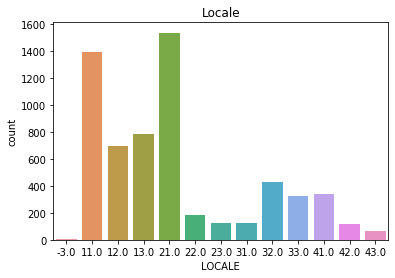

In [65]:
sns.countplot(x='LOCALE', data=college_df)
plt.title('Locale');

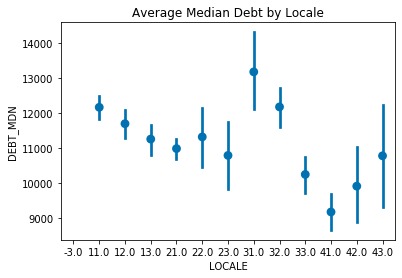

In [66]:
sns.pointplot(x= 'LOCALE', y='DEBT_MDN', data=college_df, join=False)
plt.title('Average Median Debt by Locale');

In [70]:
college_df.groupby('LOCALE')['DEBT_MDN'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
LOCALE,,,,,,,,
-3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11.0,1134.0,12168.58,5661.87,1510.0,7903.50,10704.0,16000.00,33166.0
12.0,608.0,11699.04,5306.20,2466.0,7600.00,9833.0,15416.25,29500.0
13.0,681.0,11258.64,5391.50,2251.0,7114.00,9500.0,15000.00,31750.0
21.0,1296.0,10986.58,5323.58,2200.0,6839.00,9500.0,14527.50,30666.0
22.0,160.0,11320.68,5390.41,2625.0,7000.00,9500.0,15051.75,26803.0
23.0,108.0,10790.94,5374.70,2016.0,6759.75,8607.5,15125.00,23900.0
31.0,111.0,13182.66,5872.51,3926.0,8000.00,12902.0,18500.00,27000.0
32.0,361.0,12179.67,5612.54,3000.0,7073.00,12000.0,16667.00,27090.0


In [73]:
college_df.groupby('LOCALE')['DEBT_MDN'].mean().round(2).sort_values()

LOCALE
 41.0     9172.08
 42.0     9911.08
 33.0    10246.89
 43.0    10779.88
 23.0    10790.94
 21.0    10986.58
 13.0    11258.64
 22.0    11320.68
 12.0    11699.04
 11.0    12168.58
 32.0    12179.67
 31.0    13182.66
-3.0          NaN
Name: DEBT_MDN, dtype: float64

In [72]:
len(college_df[college_df['LOCALE'] == -3])

3

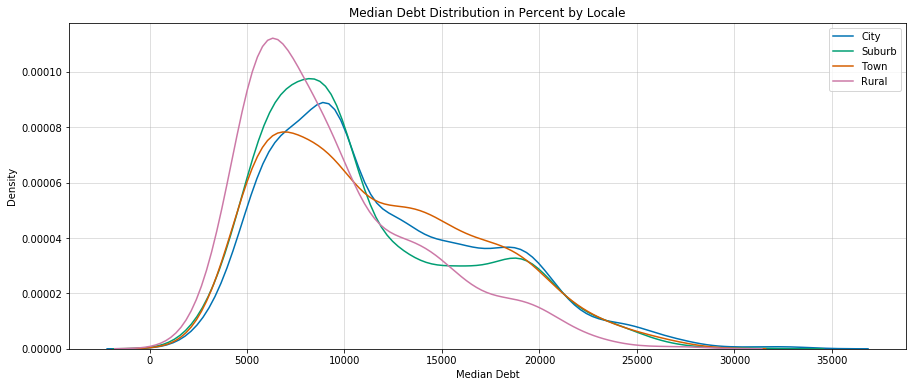

In [67]:
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
sns.kdeplot(college_df.loc[college_df['LOCALE'].isin([11,12,13]), 'DEBT_MDN'], label = 'City')
sns.kdeplot(college_df.loc[college_df['LOCALE'].isin([21,22,23]), 'DEBT_MDN'], label = 'Suburb')
sns.kdeplot(college_df.loc[college_df['LOCALE'].isin([31,32,33]), 'DEBT_MDN'], label = 'Town')
sns.kdeplot(college_df.loc[college_df['LOCALE'].isin([41,42,43]), 'DEBT_MDN'], label = 'Rural')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Median Debt Distribution in Percent by Locale');

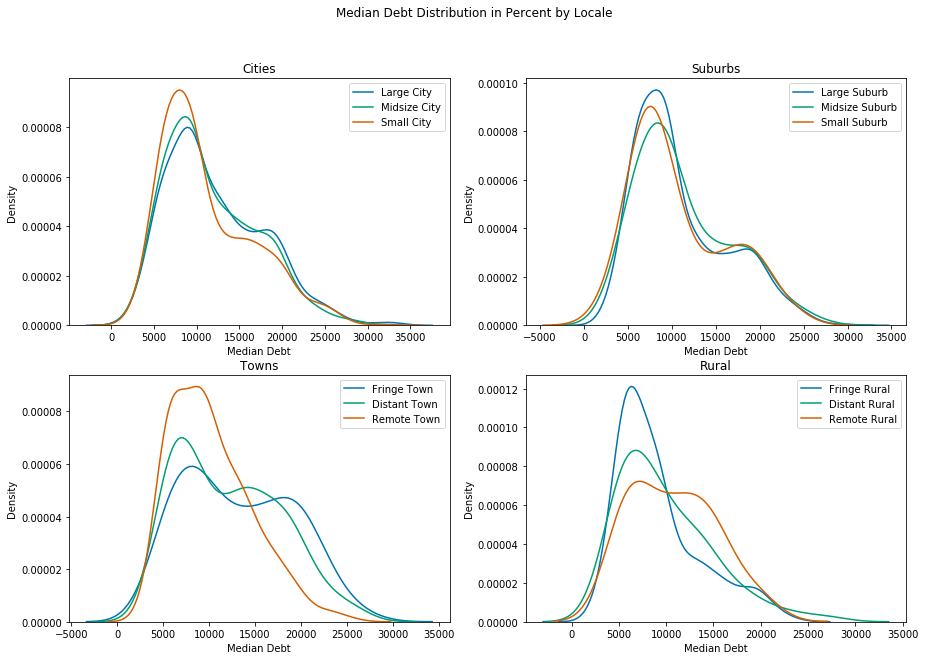

In [68]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-colorblind')
plt.grid(True, alpha=0.5)
plt.suptitle('Median Debt Distribution in Percent by Locale');

plt.subplot(2,2,1)
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==11, 'DEBT_MDN'], label = 'Large City')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==12, 'DEBT_MDN'], label = 'Midsize City')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==13, 'DEBT_MDN'], label = 'Small City')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Cities')

plt.subplot(2,2,2)
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==21, 'DEBT_MDN'], label = 'Large Suburb')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==22, 'DEBT_MDN'], label = 'Midsize Suburb')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==23, 'DEBT_MDN'], label = 'Small Suburb')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Suburbs')

plt.subplot(2,2,3)
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==31, 'DEBT_MDN'], label = 'Fringe Town')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==32, 'DEBT_MDN'], label = 'Distant Town')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==33, 'DEBT_MDN'], label = 'Remote Town')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Towns')

plt.subplot(2,2,4)
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==41, 'DEBT_MDN'], label = 'Fringe Rural')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==42, 'DEBT_MDN'], label = 'Distant Rural')
sns.kdeplot(college_df.loc[college_df['LOCALE'] ==43, 'DEBT_MDN'], label = 'Remote Rural')
plt.xlabel('Median Debt')
plt.ylabel('Density')
plt.title('Rural');

**Observations:**
- Most schools are in large cities or large suburbs.
- Average median debt is highest in fringe and distant towns. However, there are few schools in these categories, and the error bars in the point plot above indicate variability. Standard deviation is also highest in fringe towns.
- Average median debt is lowest in fringe rural areas, but again there are few occurrences. 
- Locale is not classified at three schools. These schools also did not record median debt.

### Minority-serving schools
These categorical variables represent types of minority-serving schools, where 1 is true and 0 is false. 

In [89]:
types_df = college_df[['HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'MENONLY', 'WOMENONLY', 'DEBT_MDN']]

In [90]:
types_df.isna().sum()

HBCU          391
PBI           391
ANNHI         391
TRIBAL        391
AANAPII       391
HSI             0
NANTI         391
MENONLY       386
WOMENONLY     386
DEBT_MDN     1035
dtype: int64

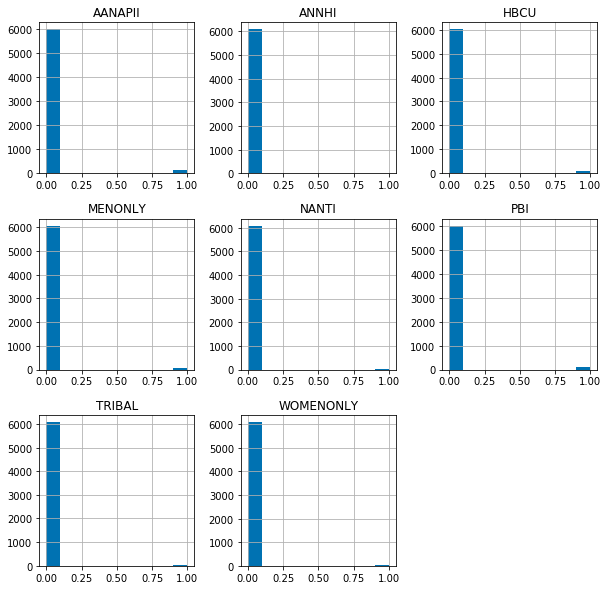

In [91]:
types_df.drop('DEBT_MDN', axis=1).hist(figsize=(10,10))
plt.show()

In [92]:
types_df.HSI.value_counts()

0     5189
0      489
1      430
NU     391
1        5
Name: HSI, dtype: int64

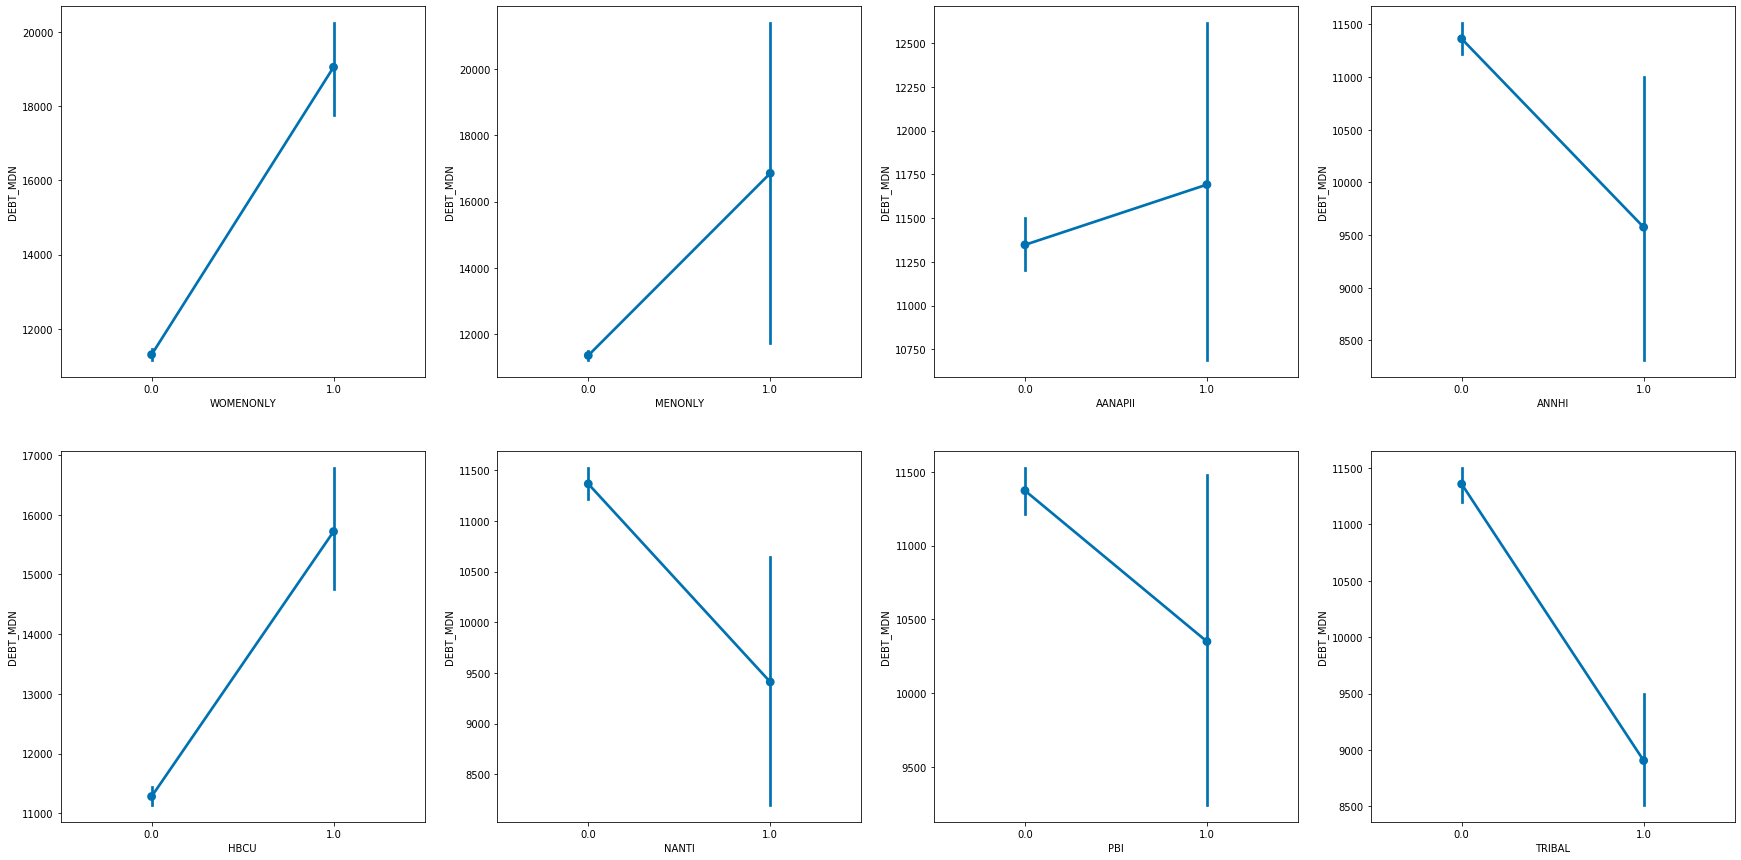

In [93]:
plt.figure(figsize=(30,15))
plt.subplot(2,4,1)
sns.pointplot(x= 'WOMENONLY', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,2)
sns.pointplot(x= 'MENONLY', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,3)
sns.pointplot(x= 'AANAPII', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,4)
sns.pointplot(x= 'ANNHI', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,5)
sns.pointplot(x= 'HBCU', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,6)
sns.pointplot(x= 'NANTI', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,7)
sns.pointplot(x= 'PBI', y='DEBT_MDN', data=types_df)

plt.subplot(2,4,8)
sns.pointplot(x= 'TRIBAL', y='DEBT_MDN', data=types_df);

**Observations:**
- These variables are imbalanced, and the majority of schools in the dataset are not minority-serving institutions
- There are data collection issues in 'HSI', the flag for Hispanic-serving schools
- Average median debt is higher at women-only schools and HBCUs; and lower at Alaska Native Native Hawaiian, Native American non-tribal, and Tribal schools.

### Admissions
These numerical variables contain information about admission rates and average SAT and ACT scores of admitted students.

In [36]:
adm_df = college_df[['ADM_RATE', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 
                     'SATVRMID', 'SATMTMID', 'ACTCM25', 'ACTCM75', 'ACTEN25', 'ACTEN75', 'ACTMT25',
                     'ACTMT75', 'ACTCMMID', 'ACTENMID', 'ACTMTMID', 'SAT_AVG', 'SAT_AVG_ALL', 'DEBT_MDN']]

In [95]:
adm_df.isna().sum()

ADM_RATE        4505
ADM_RATE_ALL    4316
SATVR25         5272
SATVR75         5272
SATMT25         5272
SATMT75         5272
SATVRMID        5272
SATMTMID        5272
ACTCM25         5220
ACTCM75         5220
ACTEN25         5300
ACTEN75         5300
ACTMT25         5300
ACTMT75         5300
ACTCMMID        5220
ACTENMID        5300
ACTMTMID        5300
SAT_AVG         5192
SAT_AVG_ALL     5071
DEBT_MDN        1035
dtype: int64

In [96]:
adm_df.describe().round(2)

,ADM_RATE,ADM_RATE_ALL,SATVR25,SATVR75,SATMT25,SATMT75,SATVRMID,SATMTMID,ACTCM25,ACTCM75,ACTEN25,ACTEN75,ACTMT25,ACTMT75,ACTCMMID,ACTENMID,ACTMTMID,SAT_AVG,SAT_AVG_ALL,DEBT_MDN
count,1999.00,2188.00,1232.00,1232.00,1232.00,1232.00,1232.00,1232.00,1284.00,1284.00,1204.00,1204.00,1204.00,1204.00,1284.00,1204.00,1204.00,1312.00,1433.00,5469.00
mean,0.68,0.68,510.85,609.49,505.59,605.69,560.21,555.68,20.55,25.83,19.63,26.08,19.44,25.44,23.45,23.11,22.69,1132.07,1138.74,11389.35
std,0.21,0.20,70.89,65.04,70.84,70.55,66.33,69.46,3.88,3.64,4.32,4.21,3.74,3.68,3.70,4.19,3.64,129.84,129.21,5326.42
min,0.00,0.00,210.00,260.00,210.00,338.00,250.00,274.00,1.00,9.00,1.00,11.00,1.00,9.00,6.00,6.00,5.00,564.00,564.00,1510.00
25%,0.55,0.56,470.00,570.00,460.00,560.00,520.00,510.00,18.00,23.00,17.00,23.00,17.00,23.00,21.00,20.00,20.00,1045.00,1047.00,7161.00
50%,0.71,0.71,500.00,610.00,500.00,592.00,555.00,545.00,20.00,26.00,19.00,25.00,18.00,25.00,23.00,23.00,22.00,1118.00,1125.00,9500.00
75%,0.84,0.83,550.00,650.00,530.00,640.00,595.00,585.00,22.00,28.00,22.00,29.00,21.00,27.00,25.00,25.00,24.00,1195.50,1204.00,15000.00
max,1.00,1.00,750.00,790.00,780.00,800.00,770.00,790.00,34.00,35.00,34.00,36.00,35.00,36.00,35.00,35.00,36.00,1558.00,1558.00,33166.00


In [100]:
# exploring schools where admission rate is 0%
# these might be schools where students were not admitted in the 2017-18 school year.
college_df[college_df['ADM_RATE'] == 0]

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOTFIRSTTIME_POOLED_SUPP,OMENRUP_NOTFIRSTTIME_POOLED_SUPP,OMENRYP_FULLTIME_POOLED_SUPP,OMENRAP_FULLTIME_POOLED_SUPP,OMAWDP8_FULLTIME_POOLED_SUPP,OMENRUP_FULLTIME_POOLED_SUPP,OMENRYP_PARTTIME_POOLED_SUPP,OMENRAP_PARTTIME_POOLED_SUPP,OMAWDP8_PARTTIME_POOLED_SUPP,OMENRUP_PARTTIME_POOLED_SUPP
2842,211635,653400,6534,Citizens School of Nursing,New Kensington,PA,15068-6525,Accreditation Commission for Education in Nursing,https://www.ahn.org/education/citizens-school-...,www.ahn.org/NetPriceCalculator/npcalc.htm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5621,480912,4219700,42197,Gemini School of Visual Arts & Communication,Cedar Park,TX,78613,Council on Occupational Education,Geminischool.com,www.geminischool.com/netprice-npcalc,...,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,NaN,NaN,NaN,NaN
6114,491288,389600,3896,University of Wisconsin-Milwaukee Flex,Milwaukee,WI,53201,Higher Learning Commission,https://flex.wisconsin.edu,https://flex.wisconsin.edu/tuition-financial-a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


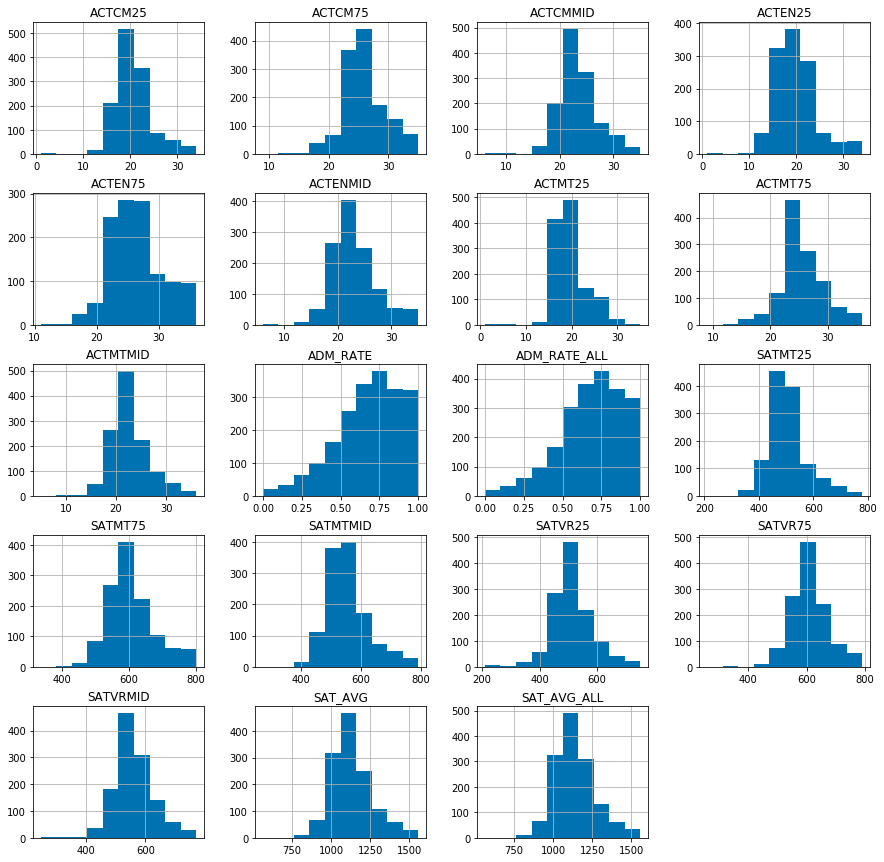

In [97]:
adm_df.drop('DEBT_MDN', axis=1).hist(figsize=(15,15))
plt.show()

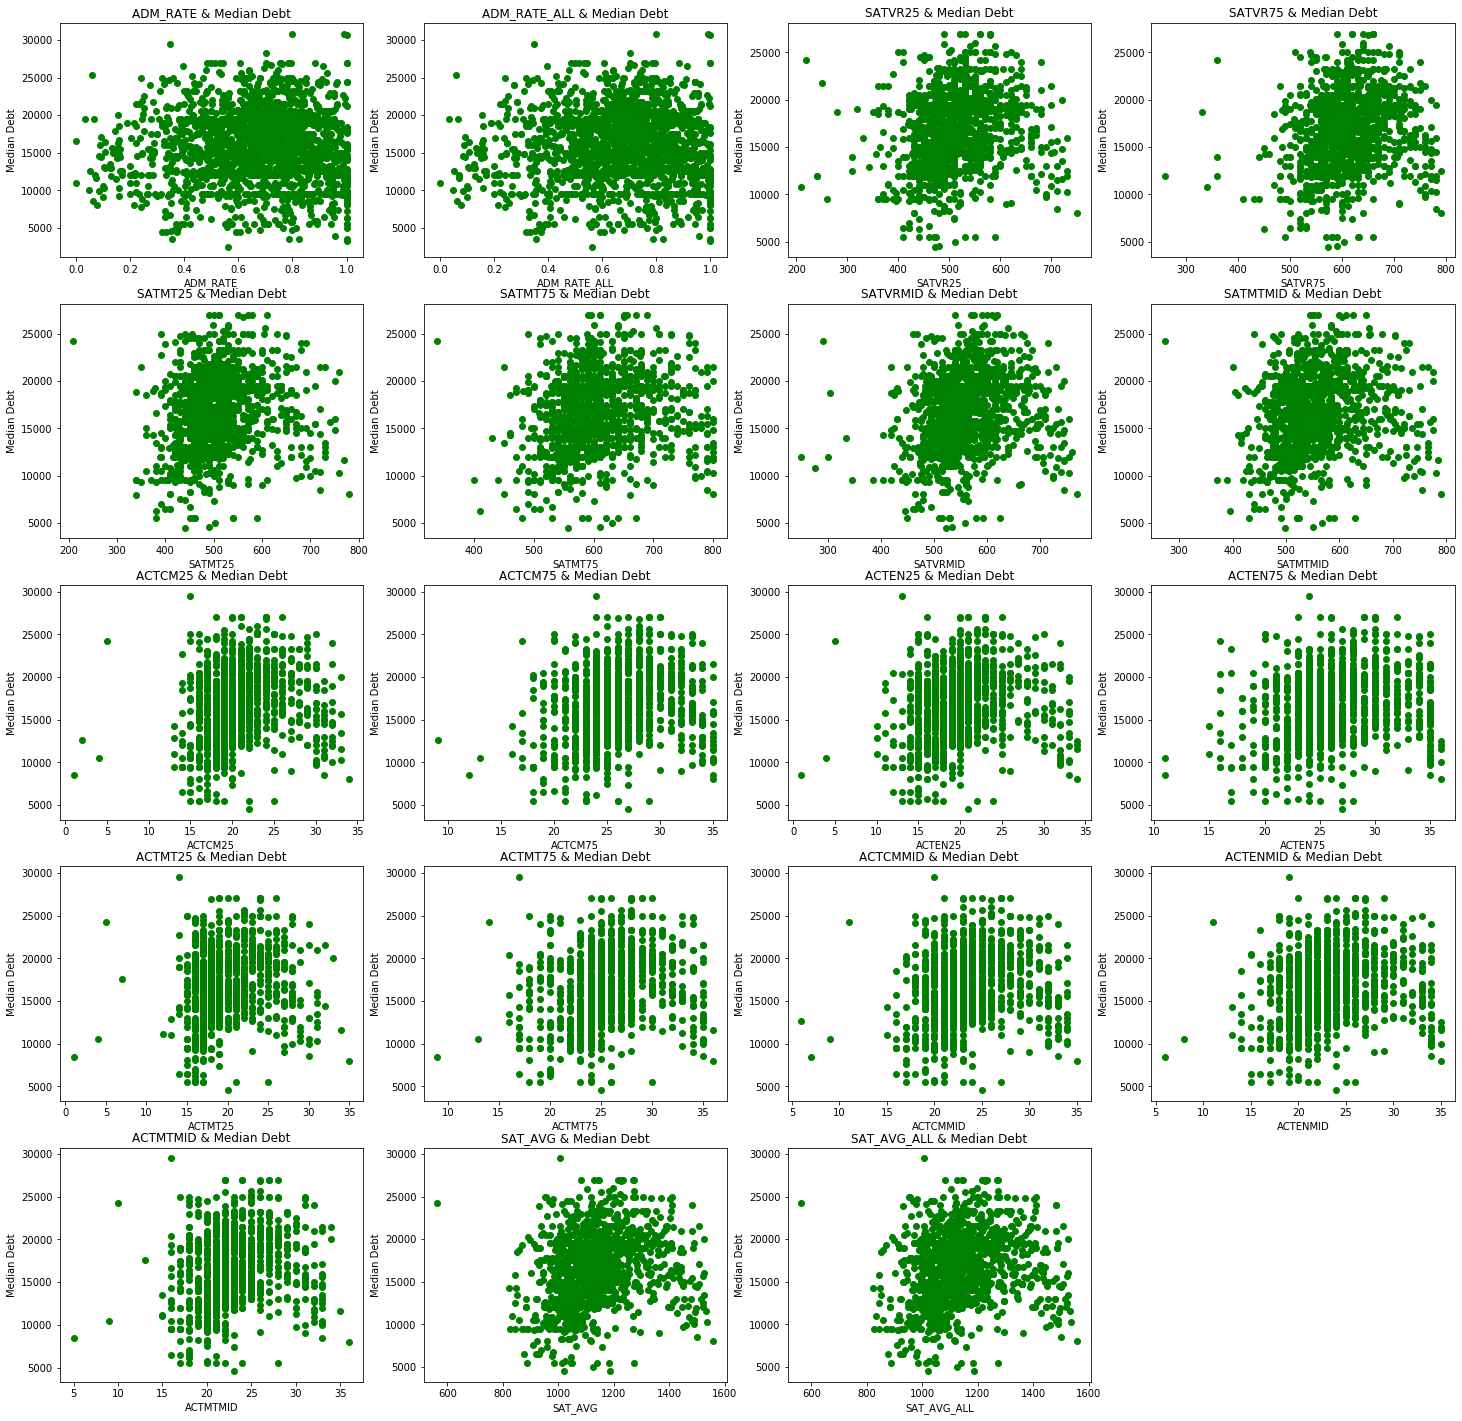

In [151]:
x = 1
plt.figure(figsize=(25,25))
for col in adm_df.drop('DEBT_MDN', axis=1):
    plt.subplot(5,4,x)
    plt.title(col + ' & Median Debt')
    plt.xlabel(col)
    plt.ylabel('Median Debt')
    plt.scatter(adm_df[col], adm_df.DEBT_MDN, color='g')
    x = x+1

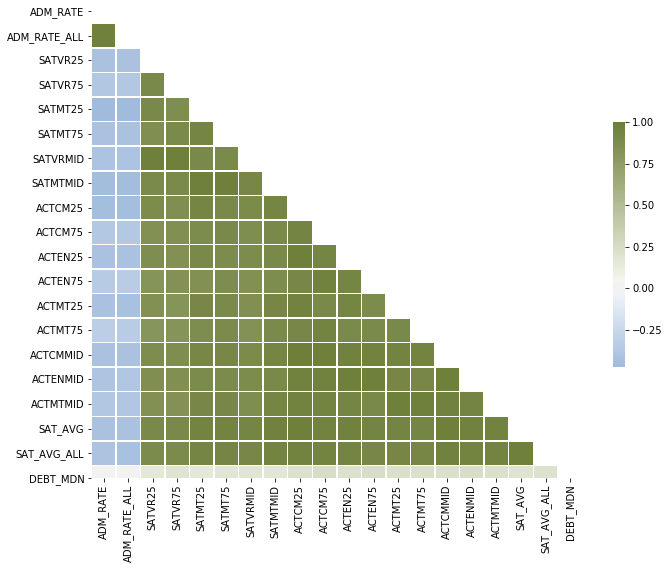

In [42]:
adm_corr = adm_df.corr()
mask = np.triu(np.ones_like(adm_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 100, as_cmap=True)
sns.heatmap(adm_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [154]:
pearsonr(college_df.dropna(subset=['SAT_AVG', 'DEBT_MDN'])['SAT_AVG'], college_df.dropna(subset=['SAT_AVG', 'DEBT_MDN'])['DEBT_MDN'])

(0.19740242658139662, 7.792715329104601e-13)

**Observations:**
- This information is not provided for most schools in the dataset.
- Admissions rate variables skew left, while test score variables appear more normal.
- These variables do not show high correlations with median debt in the scatter plots above.
- As expected, the test score variables are positively correlated with each other.
- The Pearson test showed a weak positive correlation between average SAT score and median debt that is statistically significant.

### Academic programs
These numerical values represent the percentage of degrees awarded in various disciplines.

In [104]:
prog_df = college_df[['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11', 'PCIP12', 
                      'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24',
                      'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP38', 'PCIP39',
                      'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47',
                      'PCIP48', 'PCIP49', 'PCIP50', 'PCIP51', 'PCIP52', 'PCIP54','DEBT_MDN']]

In [105]:
prog_df.isna().sum()

PCIP01       678
PCIP03       678
PCIP04       678
PCIP05       678
PCIP09       678
PCIP10       678
PCIP11       678
PCIP12       678
PCIP13       678
PCIP14       678
PCIP15       678
PCIP16       678
PCIP19       678
PCIP22       678
PCIP23       678
PCIP24       678
PCIP25       678
PCIP26       678
PCIP27       678
PCIP29       678
PCIP30       678
PCIP31       678
PCIP38       678
PCIP39       678
PCIP40       678
PCIP41       678
PCIP42       678
PCIP43       678
PCIP44       678
PCIP45       678
PCIP46       678
PCIP47       678
PCIP48       678
PCIP49       678
PCIP50       678
PCIP51       678
PCIP52       678
PCIP54       678
DEBT_MDN    1035
dtype: int64

In [106]:
prog_df.describe().round(2)

,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,...,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,DEBT_MDN
count,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,...,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5826.00,5469.00
mean,0.01,0.00,0.00,0.00,0.01,0.01,0.02,0.20,0.02,0.01,...,0.02,0.01,0.03,0.02,0.01,0.03,0.26,0.09,0.00,11389.35
std,0.04,0.02,0.02,0.01,0.05,0.05,0.06,0.38,0.06,0.06,...,0.05,0.05,0.12,0.07,0.07,0.13,0.34,0.14,0.01,5326.42
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1510.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7161.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.03,0.00,9500.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.05,0.02,0.00,...,0.00,0.00,0.00,0.00,0.00,0.02,0.36,0.15,0.00,15000.00
max,1.00,0.57,1.00,0.45,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.11,33166.00


In [107]:
prog_df.mean().sort_values(ascending=False).head()

DEBT_MDN    11389.352898
PCIP51          0.255559
PCIP12          0.199249
PCIP52          0.094131
PCIP24          0.066061
dtype: float64

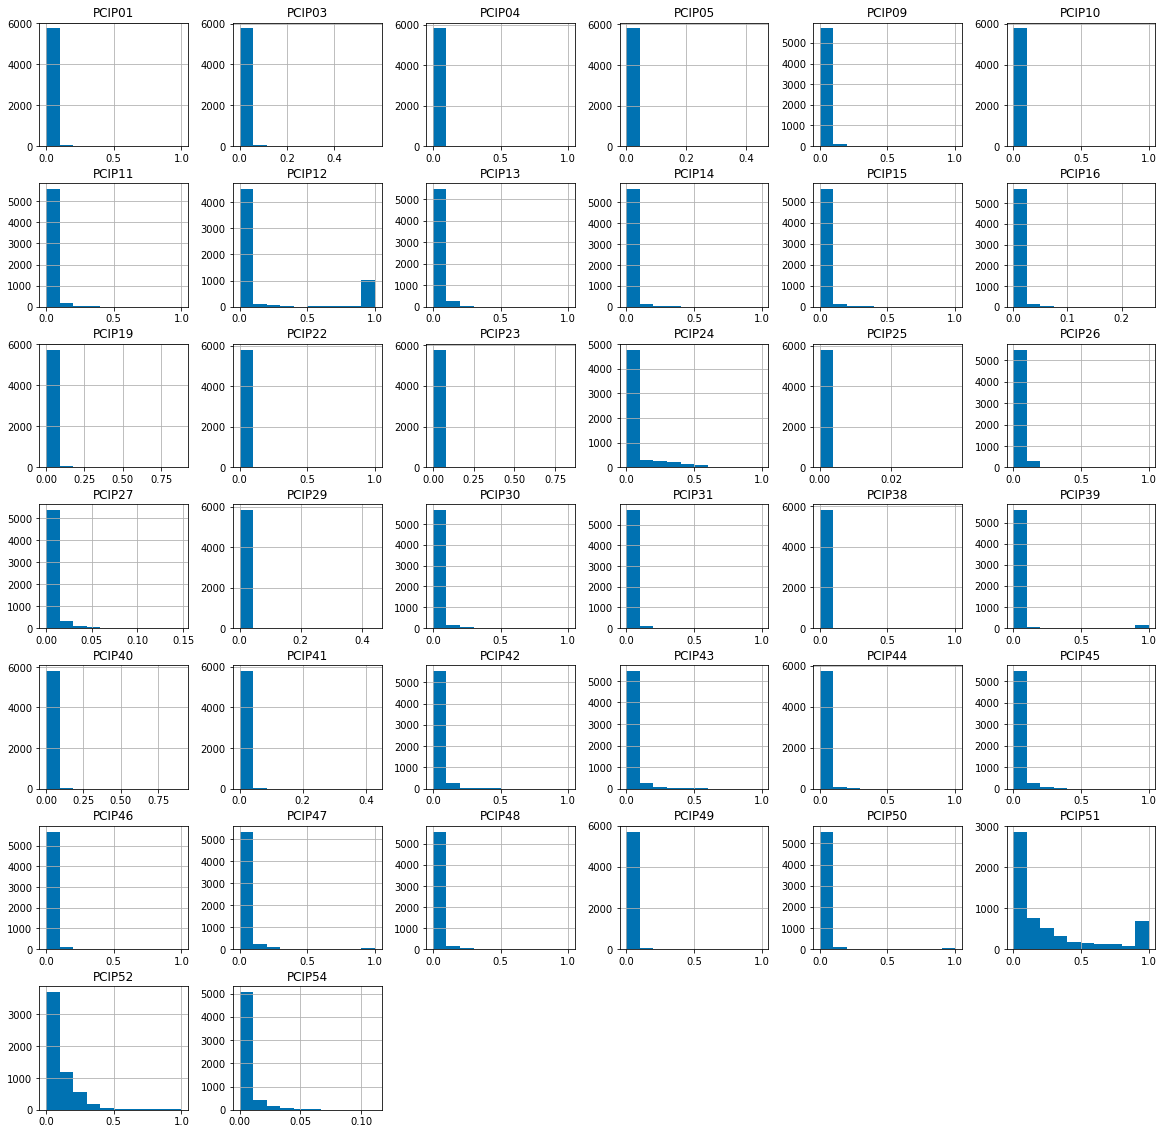

In [108]:
prog_df.drop('DEBT_MDN', axis=1).hist(figsize=(20,20))
plt.show()

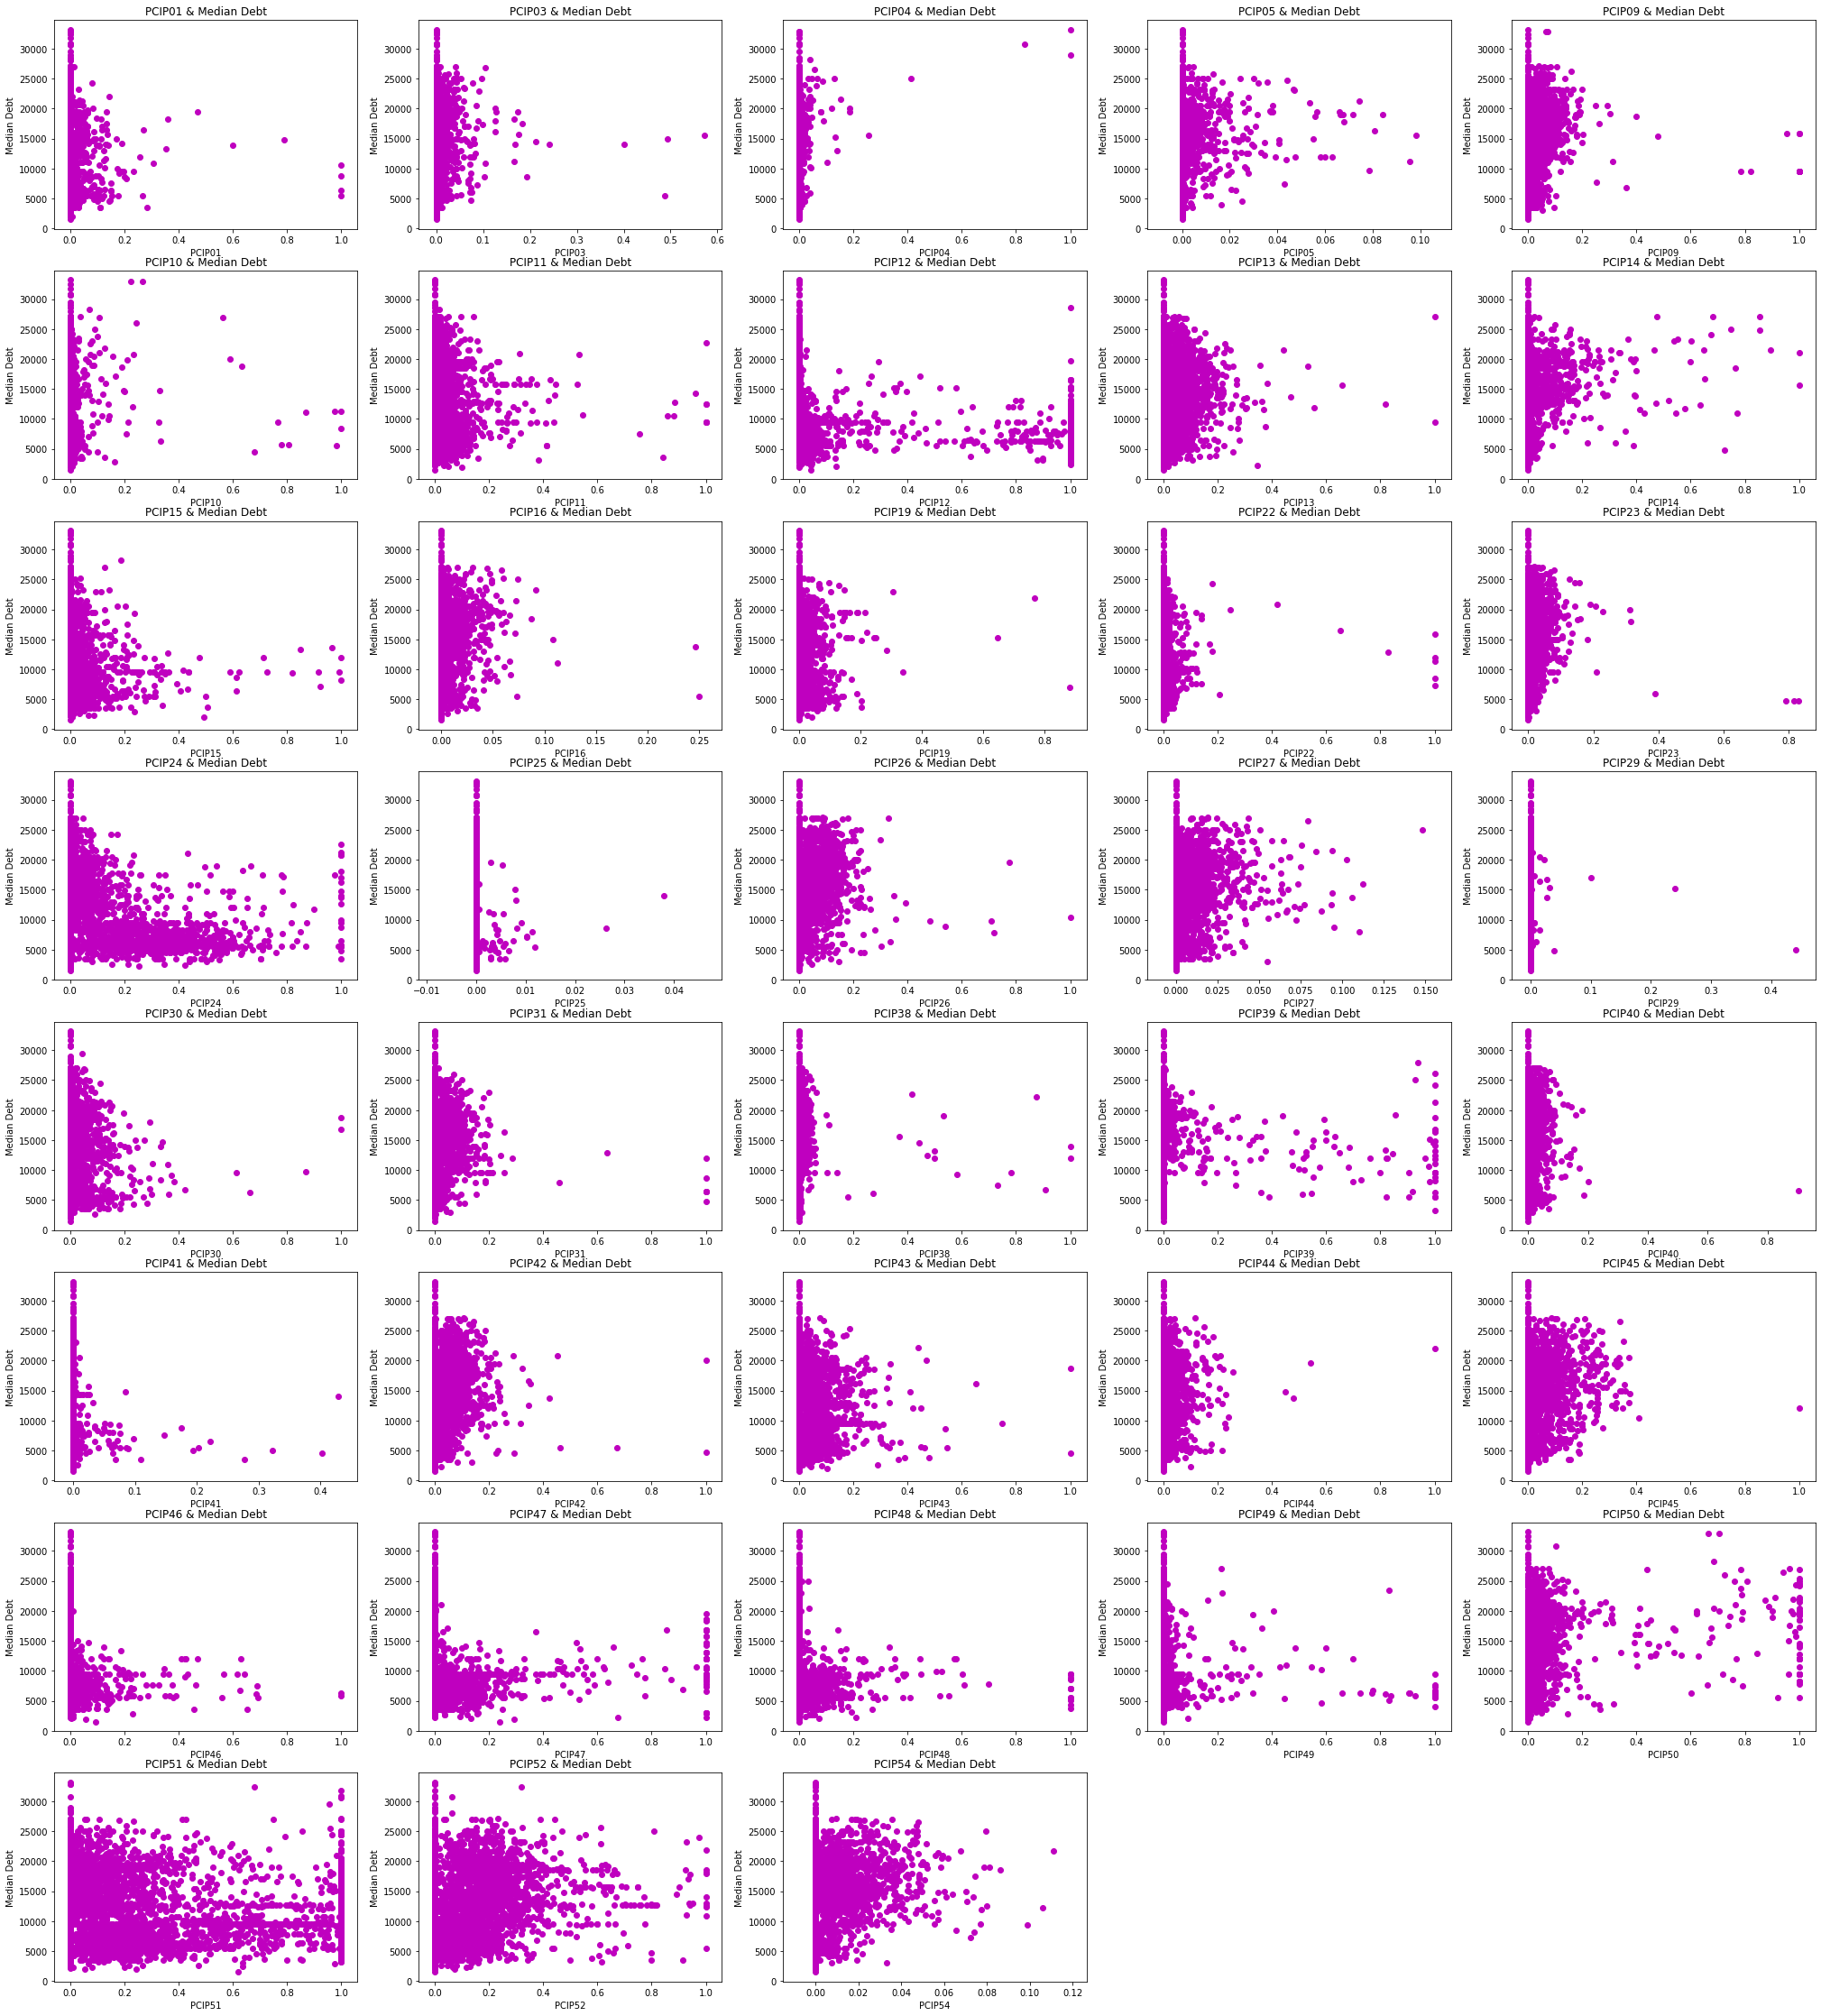

In [164]:
x = 1
plt.figure(figsize=(35,40))
for col in prog_df.drop('DEBT_MDN', axis=1):
    plt.subplot(8,5,x)
    plt.title(col + ' & Median Debt')
    plt.xlabel(col)
    plt.ylabel('Median Debt')
    plt.scatter(prog_df[col], prog_df.DEBT_MDN, color='m')
    x = x+1

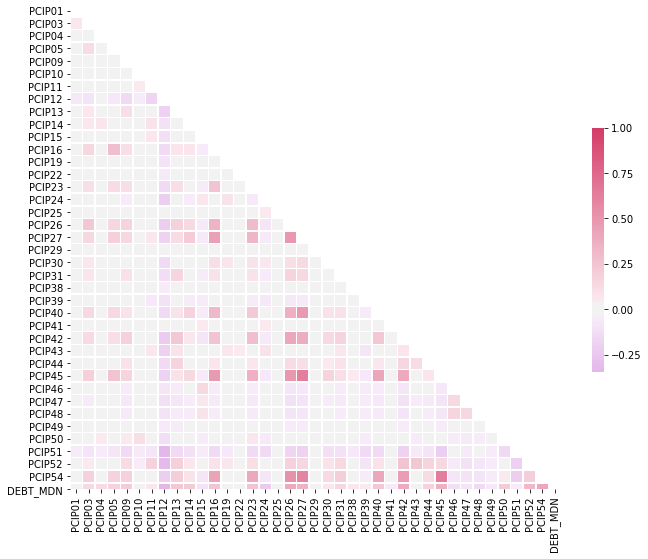

In [165]:
prog_corr = prog_df.corr()
mask = np.triu(np.ones_like(prog_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(300, 0, as_cmap=True)
sns.heatmap(prog_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [166]:
prog_corr['DEBT_MDN'].sort_values()

PCIP12     -0.335248
PCIP24     -0.239336
PCIP48     -0.137578
PCIP46     -0.115789
PCIP15     -0.094713
PCIP47     -0.086140
PCIP49     -0.065877
PCIP41     -0.058676
PCIP51     -0.050108
PCIP25     -0.029995
PCIP01     -0.015826
PCIP29     -0.004579
PCIP19      0.007278
PCIP22      0.010634
PCIP10      0.015178
PCIP43      0.023965
PCIP39      0.049658
PCIP11      0.054808
PCIP30      0.056157
PCIP38      0.065723
PCIP04      0.128826
PCIP03      0.135845
PCIP31      0.145301
PCIP05      0.176816
PCIP44      0.179308
PCIP14      0.206952
PCIP09      0.216292
PCIP50      0.219192
PCIP40      0.229927
PCIP13      0.233134
PCIP16      0.243447
PCIP23      0.253032
PCIP52      0.314335
PCIP27      0.348954
PCIP45      0.359341
PCIP42      0.389594
PCIP26      0.392309
PCIP54      0.406807
DEBT_MDN    1.000000
Name: DEBT_MDN, dtype: float64

In [168]:
pearsonr(college_df.dropna(subset=['PCIP12', 'DEBT_MDN'])['PCIP12'], college_df.dropna(subset=['PCIP12', 'DEBT_MDN'])['DEBT_MDN'])

(-0.3352483254131768, 9.540703145882124e-134)

In [167]:
pearsonr(college_df.dropna(subset=['PCIP54', 'DEBT_MDN'])['PCIP54'], college_df.dropna(subset=['PCIP54', 'DEBT_MDN'])['DEBT_MDN'])

(0.40680727262813066, 6.809486501772621e-202)

In [171]:
pearsonr(college_df.dropna(subset=['PCIP26', 'DEBT_MDN'])['PCIP26'], college_df.dropna(subset=['PCIP26', 'DEBT_MDN'])['DEBT_MDN'])

(0.392309340032251, 1.1508876522068542e-186)

In [109]:
pearsonr(college_df.dropna(subset=['PCIP42', 'DEBT_MDN'])['PCIP42'], college_df.dropna(subset=['PCIP42', 'DEBT_MDN'])['DEBT_MDN'])

(0.38959351471912285, 6.75586062750878e-184)

**Observations:**
- About 1% of these columns are null.
- For most programs, average percentage awarded is between 0 and 1%. Average degrees awarded in culinary (PCIP12) and health (PCIP51) are 20% and 27% respectively, and some schools in the dataset award all degrees in these disciplines. 
- There are statistically significant correlations between median debt and programs. Highest positive correlations are with history (PCIP54), biology (PCIP26), and psychology (PCIP42). Highest negative correlation is with culinary (PCIP12).

### Undergraduate size & demographics
These numerical variables represent the number of undergraduates (UGDS) and the percent of undergraduates by race, gender, and part-time status.

In [110]:
ugds_df = college_df[['UGDS', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN',
                      'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_MEN', 'UGDS_WOMEN',
                      'PPTUG_EF', 'DEBT_MDN']]

In [111]:
ugds_df.isna().sum()

UGDS           675
UGDS_WHITE     676
UGDS_BLACK     676
UGDS_HISP      676
UGDS_ASIAN     676
UGDS_AIAN      676
UGDS_NHPI      676
UGDS_2MOR      676
UGDS_NRA       676
UGDS_UNKN      676
UGDS_MEN       676
UGDS_WOMEN     676
PPTUG_EF       690
DEBT_MDN      1035
dtype: int64

In [112]:
ugds_df.describe().round(2)

,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,DEBT_MDN
count,5829.00,5828.00,5828.00,5828.00,5828.00,5828.00,5828.00,5828.00,5828.00,5828.00,5828.00,5828.00,5814.00,5469.00
mean,2626.74,0.51,0.18,0.18,0.04,0.01,0.00,0.03,0.02,0.03,0.36,0.64,0.23,11389.35
std,5676.63,0.28,0.21,0.23,0.08,0.07,0.03,0.04,0.06,0.07,0.24,0.24,0.25,5326.42
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1510.00
25%,117.00,0.27,0.04,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.53,0.00,7161.00
50%,498.00,0.55,0.09,0.09,0.01,0.00,0.00,0.02,0.00,0.01,0.38,0.62,0.13,9500.00
75%,2291.00,0.74,0.23,0.22,0.04,0.01,0.00,0.04,0.02,0.04,0.47,0.85,0.40,15000.00
max,77269.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91,1.00,1.00,1.00,1.00,1.00,33166.00


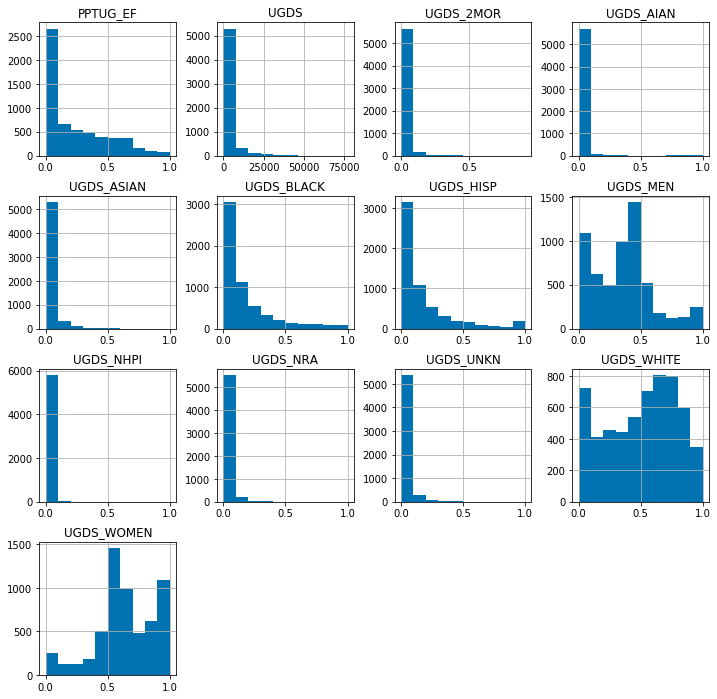

In [113]:
ugds_df.drop('DEBT_MDN', axis=1).hist(figsize=(12,12))
plt.show()

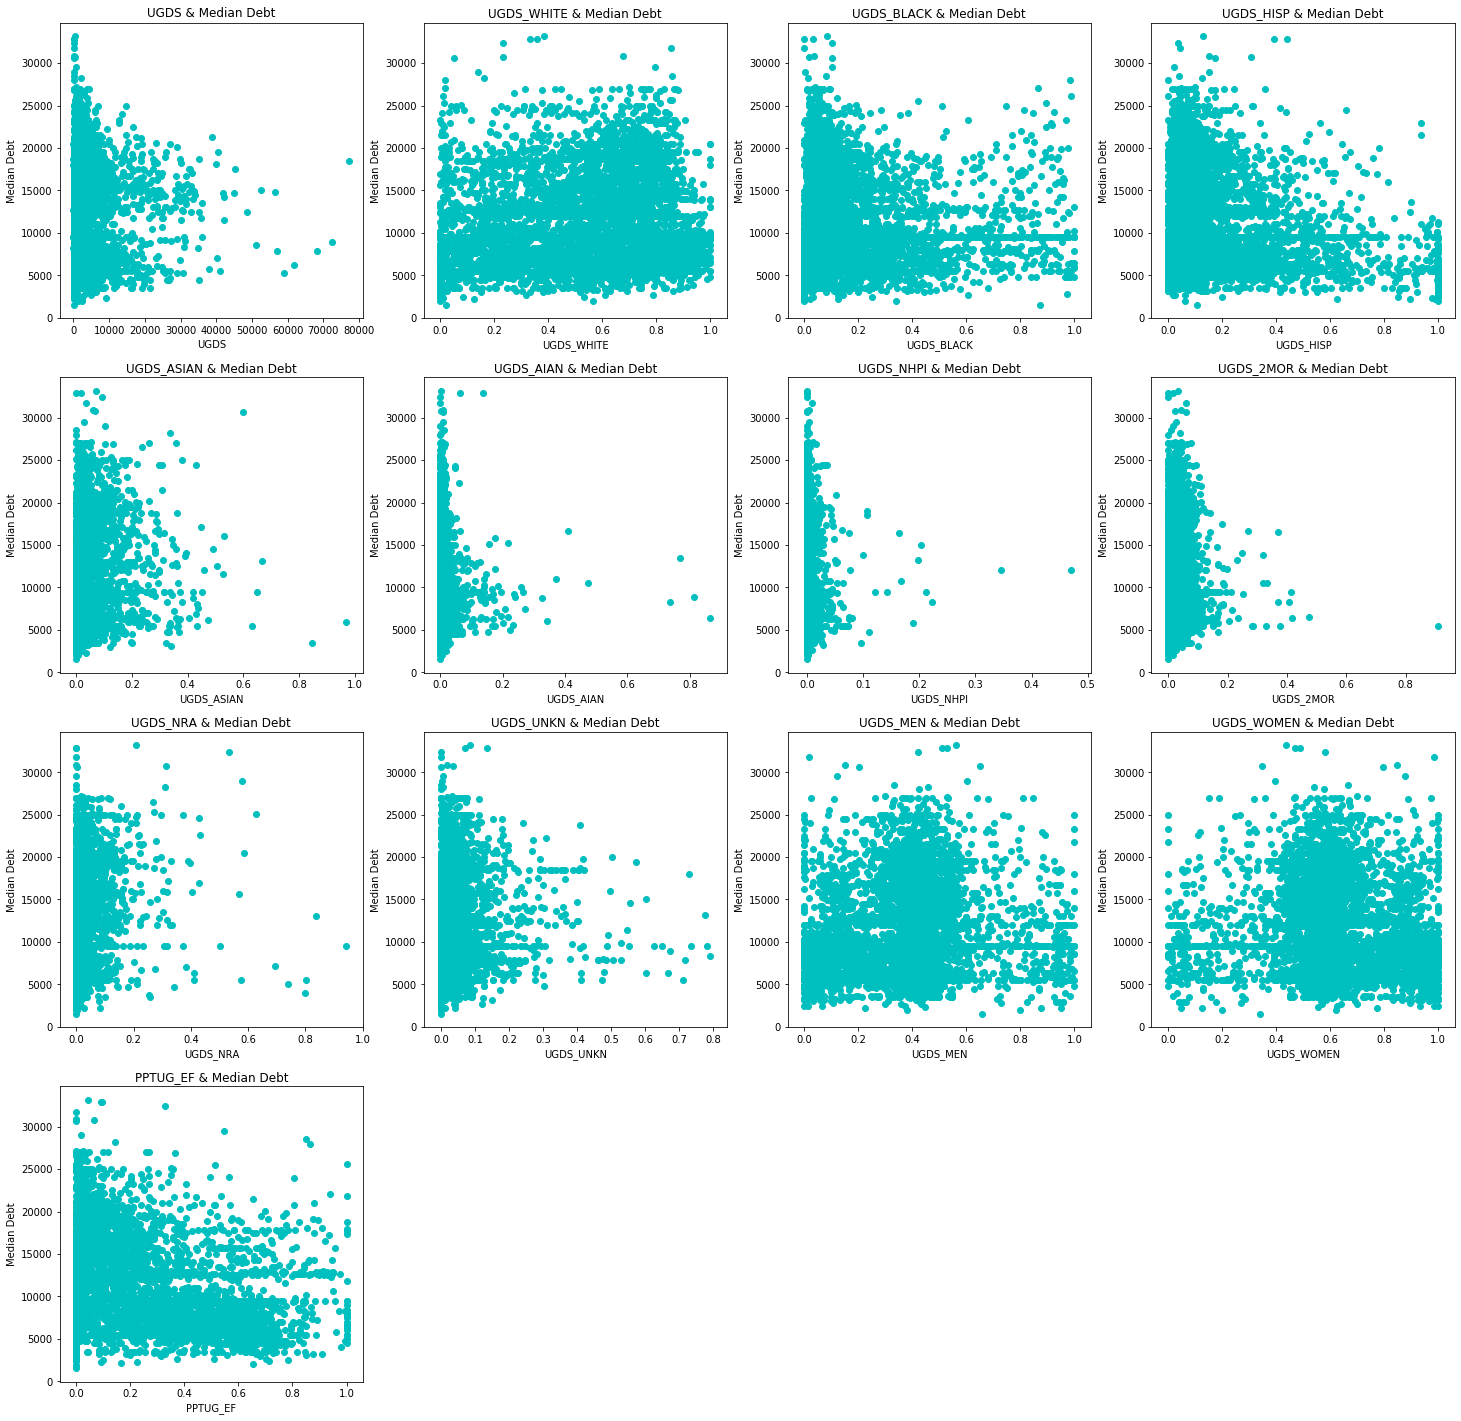

In [114]:
x = 1
plt.figure(figsize=(25,25))
for col in ugds_df.drop('DEBT_MDN', axis=1):
    plt.subplot(4,4,x)
    plt.title(col + ' & Median Debt')
    plt.xlabel(col)
    plt.ylabel('Median Debt')
    plt.scatter(ugds_df[col], ugds_df.DEBT_MDN, color='c')
    x = x+1

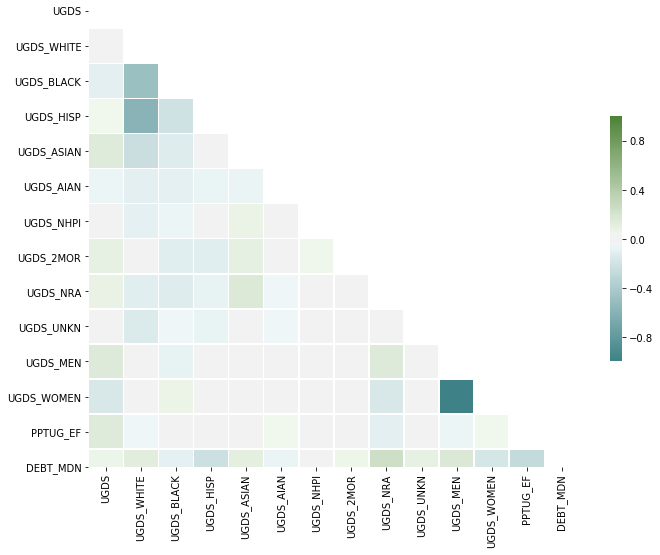

In [115]:
ugds_corr = ugds_df.corr()
mask = np.triu(np.ones_like(ugds_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(200, -600, as_cmap=True)
sns.heatmap(ugds_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [116]:
ugds_corr['DEBT_MDN'].sort_values()

PPTUG_EF     -0.266558
UGDS_HISP    -0.216845
UGDS_WOMEN   -0.168191
UGDS_BLACK   -0.091146
UGDS_AIAN    -0.053736
UGDS_NHPI    -0.009056
UGDS_2MOR     0.061588
UGDS          0.069101
UGDS_UNKN     0.100697
UGDS_ASIAN    0.119786
UGDS_WHITE    0.135195
UGDS_MEN      0.168801
UGDS_NRA      0.245297
DEBT_MDN      1.000000
Name: DEBT_MDN, dtype: float64

In [181]:
pearsonr(college_df.dropna(subset=['PPTUG_EF', 'DEBT_MDN'])['PPTUG_EF'], college_df.dropna(subset=['PPTUG_EF', 'DEBT_MDN'])['DEBT_MDN'])

(-0.2665580420563254, 2.0837148541906156e-83)

In [182]:
pearsonr(college_df.dropna(subset=['UGDS_NRA', 'DEBT_MDN'])['UGDS_NRA'], college_df.dropna(subset=['UGDS_NRA', 'DEBT_MDN'])['DEBT_MDN'])

(0.24529678922228243, 1.452258975176176e-70)

In [51]:
# colleges with over 40% international students
college_df[college_df['UGDS_NRA'] > .4][['INSTNM','CITY','STABBR','HIGHDEG', 'CONTROL','DEBT_MDN']]

,INSTNM,CITY,STABBR,HIGHDEG,CONTROL,DEBT_MDN
336,Lincoln University,Oakland,CA,4,2,32429.0
376,Musicians Institute,Hollywood,CA,3,3,6334.0
398,Pacific States University,Los Angeles,CA,4,2,NaN
472,Southern California Institute of Architecture,Los Angeles,CA,4,2,29000.0
1018,Taylor Business Institute,Chicago,IL,2,3,7182.0
1107,Divine Word College,Epworth,IA,3,2,NaN
1437,Hult International Business School,Cambridge,MA,4,2,5500.0
1494,Longy School of Music of Bard College,Cambridge,MA,4,2,20500.0
1515,The New England Conservatory of Music,Boston,MA,4,2,24568.0
1977,Assumption College for Sisters,Denville,NJ,2,2,NaN


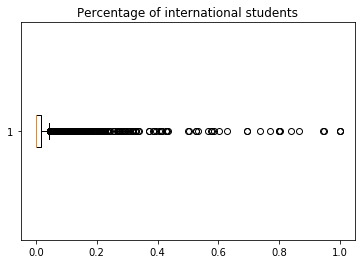

In [53]:
plt.boxplot(college_df.dropna(subset=['UGDS_NRA'])['UGDS_NRA'], vert=False)
plt.title('Percentage of international students');

In [50]:
pearsonr(college_df.dropna(subset=['UGDS_WOMEN', 'DEBT_MDN'])['UGDS_WOMEN'], college_df.dropna(subset=['UGDS_WOMEN', 'DEBT_MDN'])['DEBT_MDN'])

(-0.16819103516905337, 1.4016488166173464e-33)

In [180]:
ugds_corr['UGDS'].sort_values()

UGDS_WOMEN   -0.154913
UGDS_BLACK   -0.104709
UGDS_AIAN    -0.046434
UGDS_NHPI    -0.018835
UGDS_WHITE   -0.016847
UGDS_UNKN    -0.000477
UGDS_HISP     0.048900
DEBT_MDN      0.069101
UGDS_NRA      0.090102
UGDS_2MOR     0.104136
UGDS_ASIAN    0.144072
PPTUG_EF      0.150345
UGDS_MEN      0.156906
UGDS          1.000000
Name: UGDS, dtype: float64

**Observations:**
- These columns are about 1% null. 
- On average, undergraduates are 64% women and 36% men; 23% part-time; and 51% white, 18% black, and 18% hispanic. Other races make up less than 1%.
- Median debt is positively correlated with the percentage of international students. Art and theological schools seem to attract students from abroad in higher numbers.
- Median debt is negatively correlated with the percentage of part-time students.
- Interestingly, total undergraduate population has a negative correlation with female students and positive correlation with male students.

### Faculty
These numerial values represent the percentage of faculty who are full-time and the average faculty salary.

In [117]:
fac_df = college_df[['PFTFAC', 'AVGFACSAL', 'DEBT_MDN']]

In [118]:
fac_df.isna().sum()

PFTFAC       2885
AVGFACSAL    2544
DEBT_MDN     1035
dtype: int64

In [128]:
print('PFTFAC nulls: {}%'.format(round(college_df.PFTFAC.isna().sum()/len(college_df)*100)))
print('AVGFACSAL nulls: {}%'.format(round(college_df.AVGFACSAL.isna().sum()/len(college_df)*100)))

PFTFAC nulls: 44.0%
AVGFACSAL nulls: 39.0%


In [185]:
fac_df.describe().round(2)

,PFTFAC,AVGFACSAL,DEBT_MDN
count,3619.00,3960.00,5469.00
mean,0.59,6753.79,11389.35
std,0.29,2457.11,5326.42
min,0.00,0.00,1510.00
25%,0.34,5134.75,7161.00
50%,0.57,6498.50,9500.00
75%,0.88,8080.75,15000.00
max,1.00,22924.00,33166.00


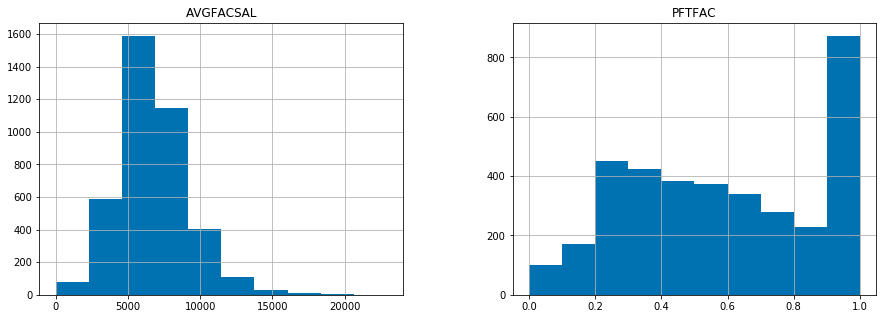

In [189]:
fac_df.drop('DEBT_MDN', axis=1).hist(figsize=(15,5))
plt.show()

In [131]:
# looking at schools where 100% of faculty are part-time
college_df[college_df['PFTFAC'] == 1]

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOTFIRSTTIME_POOLED_SUPP,OMENRUP_NOTFIRSTTIME_POOLED_SUPP,OMENRYP_FULLTIME_POOLED_SUPP,OMENRAP_FULLTIME_POOLED_SUPP,OMAWDP8_FULLTIME_POOLED_SUPP,OMENRUP_FULLTIME_POOLED_SUPP,OMENRYP_PARTTIME_POOLED_SUPP,OMENRAP_PARTTIME_POOLED_SUPP,OMAWDP8_PARTTIME_POOLED_SUPP,OMENRUP_PARTTIME_POOLED_SUPP
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,0.4647,0.1912,0.0148,0.3284,0.4391,0.2177,0.028,0.3645,0.4486,0.1589
23,101453,2199700,21997,Heritage Christian University,Florence,AL,35630-9977,Association for Bibical Higher Educaiton,www.hcu.edu,www.hcu.edu/netpricecalculator/,...,0.2368,0.7632,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,0,0,0.1333,0.8667
24,101462,526000,5260,J. F. Drake State Community and Technical College,Huntsville,AL,35811,Southern Association of Colleges and Schools C...,www.drakestate.edu,www.drakestate.edu/admissions/net_price_calcul...,...,0.3815,0.321,0.0054,0.3074,0.3243,0.3629,0.0038,0.3094,0.2541,0.4327
25,101471,3002500,30025,J F Ingram State Technical College,Deatsville,AL,36022,Council on Occupational Education,www.istc.edu,nces.ed.gov/ipeds/netpricecalculator/Npc_2.aspx,...,0.1792,0.8113,0.004,0,0.4279,0.5681,0.0097,0,0.2379,0.7524
36,101693,102900,1029,University of Mobile,Mobile,AL,36613-2842,Southern Association of Colleges and Schools C...,www.umobile.edu,umobile.edu/financial-aid/cost-calculator/,...,0.6132,0.3553,0.0013,0.0171,0.5033,0.4783,0,0.041,0.4754,0.4836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946,487524,204300,2043,Husson University,Bangor,ME,04401-2929,New England Commission on Higher Education,www.husson.edu,https://npc.collegeboard.org/student/app/husson,...,0.593,0.3657,0.0037,0.0974,0.5019,0.397,0.0126,0.0251,0.5021,0.4603
5961,487861,4235000,42350,Felbry College School of Nursing,Columbus,OH,43231-2256,Accrediting Bureau of Health Education Schools,felbrycollege.edu/,felbrycollege.edu/financial-aid/,...,NaN,NaN,0,0.1042,0.4583,0.4375,NaN,NaN,NaN,NaN
6007,488527,4256800,42568,Arkansas Colleges of Health Education,Fort Smith,AR,72916-0366,American Osteopathic Association,acheedu.org,arcomedu.org,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6008,488679,30182251,1822,Indiana Wesleyan University-National & Global,Marion,IN,46953,Higher Learning Commission,https://www.indwes.edu,https://secure2.indwes.edu/Financial-Aid/Estim...,...,0.7357,0.1466,0.0051,0.1343,0.6654,0.1953,0,0.2064,0.5459,0.2477


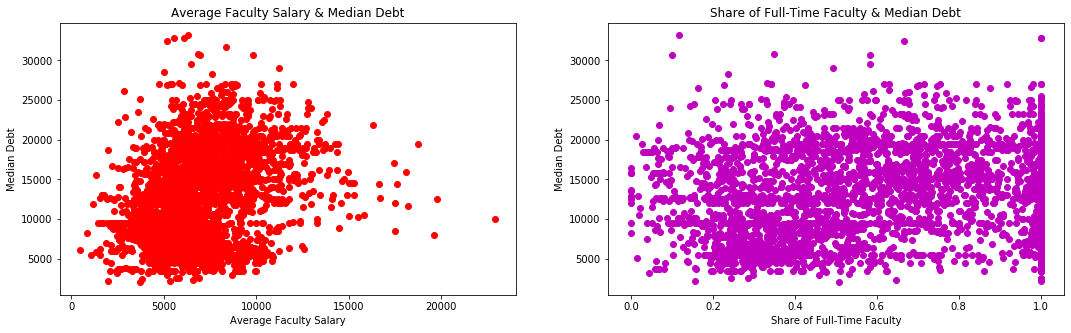

In [191]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.scatter(college_df.AVGFACSAL, college_df.DEBT_MDN, color='r')
plt.title('Average Faculty Salary & Median Debt')
plt.ylabel('Median Debt')
plt.xlabel('Average Faculty Salary')

plt.subplot(1,2,2)
plt.scatter(college_df.PFTFAC, college_df.DEBT_MDN, color = 'm')
plt.title('Share of Full-Time Faculty & Median Debt')
plt.ylabel('Median Debt')
plt.xlabel('Share of Full-Time Faculty');

In [205]:
fac_corr

,PFTFAC,AVGFACSAL,DEBT_MDN
PFTFAC,1.000000,0.123058,0.155810
AVGFACSAL,0.123058,1.000000,0.305079
DEBT_MDN,0.155810,0.305079,1.000000


In [206]:
pearsonr(college_df.dropna(subset=['AVGFACSAL', 'DEBT_MDN'])['AVGFACSAL'], college_df.dropna(subset=['AVGFACSAL', 'DEBT_MDN'])['DEBT_MDN'])

(0.30507946338414577, 2.145842087299272e-74)

**Observations:**
- These columns are about 40% null. 
- The distribution for average salary appears normal, while percent of part-time faculty skews left. There are over 600 schools that only employee part-time teachers. 
- Surprisingly, these varaibles are are not highly correlated with each other. 
- Average faculty salary has a positive correlation with median debt.

# Target & Feature Engineering

In [12]:
college_df['DEBT_MDN'].isna().sum()

1035

In [54]:
# copying the dataset
college_df2 = college_df.copy()

In [55]:
# dropping 1035 rows where target is null
college_df2.dropna(subset=['DEBT_MDN'],axis=0, inplace=True)

In [56]:
# reseting index
college_df2 = college_df2.reset_index(drop=True)

In [57]:
college_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5469 entries, 0 to 5468
Columns: 641 entries, UNITID to OMENRUP_PARTTIME_POOLED_SUPP
dtypes: float64(528), int64(14), object(99)
memory usage: 26.7+ MB


## Categorical features

In [58]:
# creating binary flag where highest degree is certificate or associate
college_df2['cert_assc'] = np.where(college_df2.HIGHDEG.isin([1,2]),1,0)

In [59]:
# creating binary variables for 2/3 control categories
college_df2['public'] = np.where(college_df2.CONTROL == 1,1,0)
college_df2['private_non'] = np.where(college_df2.CONTROL == 2,1,0)

In [60]:
# creating binary variable for colleges in New England, Mid East, Great Lakes, or Plains
# these regions have the highest average median debt
college_df2['east_mid'] = np.where(college_df2.REGION.isin([1,2,3,4]),1,0)

In [61]:
# creating binary variable for colleges in cities and large suburbs
college_df2['urban'] = np.where(college_df2.LOCALE.isin([11,12,13,21]),1,0)

## Numerical features

### Percent of part-time students

In [21]:
college_df2.PPTUG_EF.isna().sum()

387

In [62]:
# filling 387 nulls with mean
college_df2.PPTUG_EF.fillna(college_df2.PPTUG_EF.mean(), inplace=True)

In [63]:
college_df2['PPTUG_EF'].describe().round(2)

count    5469.00
mean        0.23
std         0.24
min         0.00
25%         0.01
50%         0.16
75%         0.37
max         1.00
Name: PPTUG_EF, dtype: float64

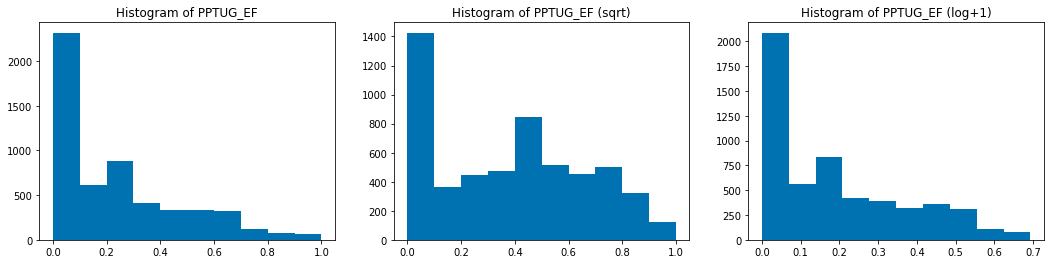

In [288]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.hist(college_df2.PPTUG_EF)
plt.title('Histogram of PPTUG_EF')

plt.subplot(1,3,2)
plt.hist(np.sqrt(college_df2.PPTUG_EF))
plt.title('Histogram of PPTUG_EF (sqrt)')

plt.subplot(1,3,3)
plt.hist(np.log(college_df2.PPTUG_EF + 1))
plt.title('Histogram of PPTUG_EF (log+1)');

In [294]:
print(stats.normaltest(college_df2.PPTUG_EF))
print(stats.normaltest(np.sqrt(college_df2.PPTUG_EF)))
print(stats.normaltest(np.log(college_df2.PPTUG_EF + 1)))

NormaltestResult(statistic=671.0652890639602, pvalue=1.9055659387175851e-146)
NormaltestResult(statistic=3748.533166034425, pvalue=0.0)
NormaltestResult(statistic=523.1756170131574, pvalue=2.4766134800308483e-114)


In [290]:
sqrt_PPTUGEF = np.sqrt(college_df2.PPTUG_EF)
log_PPTUGEF = np.log(college_df2.PPTUG_EF + 1)

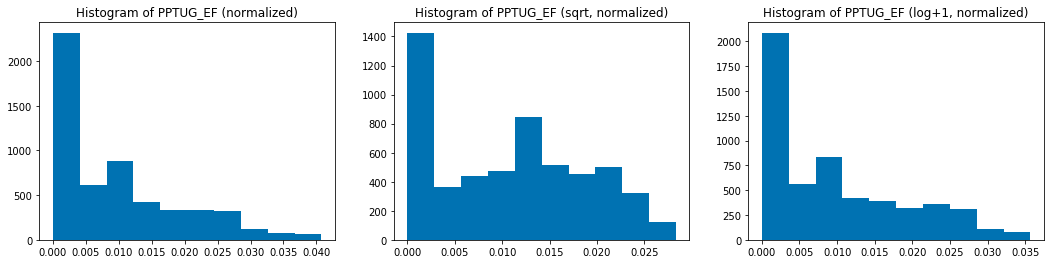

In [291]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.hist(normalize(np.array(college_df2.PPTUG_EF).reshape(1,-1)).reshape(-1,1))
plt.title('Histogram of PPTUG_EF (normalized)')

plt.subplot(1,3,2)
plt.hist(normalize(np.array(sqrt_PPTUGEF).reshape(1,-1)).reshape(-1,1))
plt.title('Histogram of PPTUG_EF (sqrt, normalized)')

plt.subplot(1,3,3)
plt.hist(normalize(np.array(log_PPTUGEF).reshape(1,-1)).reshape(-1,1))
plt.title('Histogram of PPTUG_EF (log+1, normalized)');

In [297]:
print(stats.normaltest(normalize(np.array(college_df2.PPTUG_EF).reshape(1,-1)).reshape(-1,1)))
print(stats.normaltest(normalize(np.array(sqrt_PPTUGEF).reshape(1,-1)).reshape(-1,1)))
print(stats.normaltest(normalize(np.array(log_PPTUGEF).reshape(1,-1)).reshape(-1,1)))

NormaltestResult(statistic=array([671.06528906]), pvalue=array([1.90556594e-146]))
NormaltestResult(statistic=array([3748.53316603]), pvalue=array([0.]))
NormaltestResult(statistic=array([523.17561701]), pvalue=array([2.47661348e-114]))


In [301]:
len(college_df2[college_df2['PPTUG_EF'] == 0])

1283

In [302]:
1283/ len(college_df2)

0.23459498994331687

1,283 (about 23%) of schools have no part-time students. The transformations I tried above did not normalize this variable. I'll try standardizing the original values in my model and revisit if accuracy is low. 

### Average faculty salary

In [24]:
college_df2.AVGFACSAL.isna().sum()

2058

In [64]:
# filling 2058 nulls with the mean
college_df2.AVGFACSAL.fillna(college_df2.AVGFACSAL.mean(), inplace=True)

In [65]:
college_df2['AVGFACSAL'].describe().round(2)

count     5469.00
mean      6902.65
std       1861.37
min        504.00
25%       6129.00
50%       6902.65
75%       7200.00
max      22924.00
Name: AVGFACSAL, dtype: float64

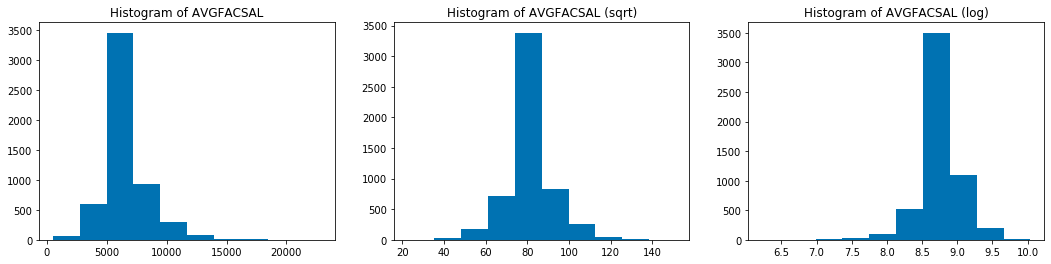

In [306]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.hist(college_df2.AVGFACSAL)
plt.title('Histogram of AVGFACSAL')

plt.subplot(1,3,2)
plt.hist(np.sqrt(college_df2.AVGFACSAL))
plt.title('Histogram of AVGFACSAL (sqrt)')

plt.subplot(1,3,3)
plt.hist(np.log(college_df2.AVGFACSAL))
plt.title('Histogram of AVGFACSAL (log)');

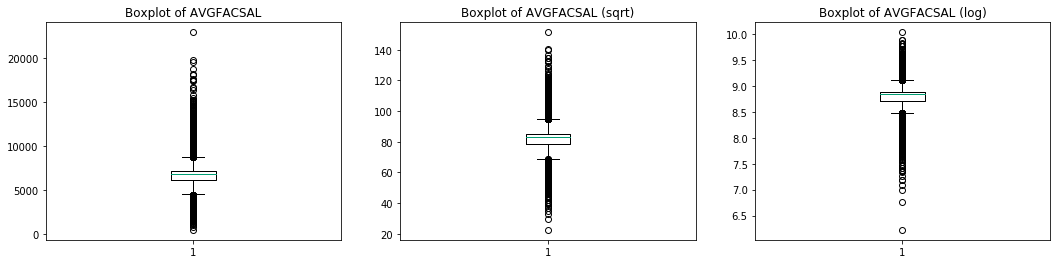

In [321]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.boxplot(college_df2.AVGFACSAL)
plt.title('Boxplot of AVGFACSAL')

plt.subplot(1,3,2)
plt.boxplot(np.sqrt(college_df2.AVGFACSAL))
plt.title('Boxplot of AVGFACSAL (sqrt)')

plt.subplot(1,3,3)
plt.boxplot(np.log(college_df2.AVGFACSAL))
plt.title('Boxplot of AVGFACSAL (log)');

In [307]:
print(stats.normaltest(college_df2.AVGFACSAL))
print(stats.normaltest(np.sqrt(college_df2.AVGFACSAL)))
print(stats.normaltest(np.log(college_df2.AVGFACSAL)))

NormaltestResult(statistic=1464.646190567455, pvalue=0.0)
NormaltestResult(statistic=425.99541156846567, pvalue=3.135246703259333e-93)
NormaltestResult(statistic=1387.3396589664214, pvalue=5.533766025358471e-302)


In [308]:
sqrt_AVGFACSAL = np.sqrt(college_df2.AVGFACSAL)

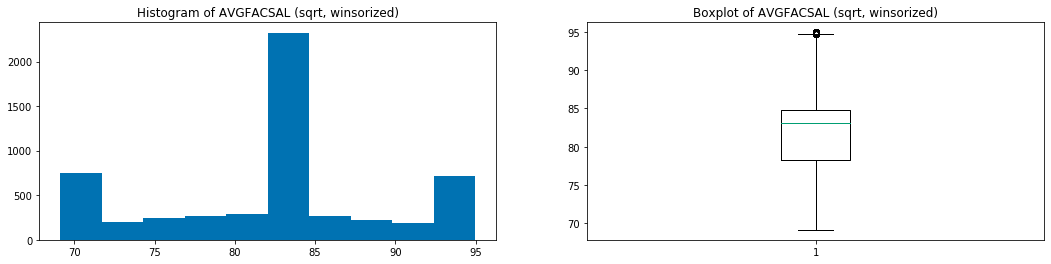

In [331]:
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
plt.hist(winsorize(sqrt_AVGFACSAL, (.1,.1)))
plt.title('Histogram of AVGFACSAL (sqrt, winsorized)')

plt.subplot(1,2,2)
plt.boxplot(winsorize(sqrt_AVGFACSAL, (.1,.1)))
plt.title('Boxplot of AVGFACSAL (sqrt, winsorized)');

About 38% of this column is null. Again, the transformations I tried above did not normalize the variable, so I'll try standardizing the original values in my model.

## Target

In [66]:
college_df2.DEBT_MDN.describe().round(2)

count     5469.00
mean     11389.35
std       5326.42
min       1510.00
25%       7161.00
50%       9500.00
75%      15000.00
max      33166.00
Name: DEBT_MDN, dtype: float64

In [67]:
# creating variable to indicate when median debt is greater than $10,000.
college_df2['high_debt'] = np.where(college_df2.DEBT_MDN > 10000,1,0)

In [68]:
college_df2.high_debt.value_counts()

0    2910
1    2559
Name: high_debt, dtype: int64

# Models

In [69]:
# defining target
y = college_df2.high_debt

# defining feature set
X = college_df2[['cert_assc', 'public', 'private_non', 'east_mid', 'urban',
                 'PPTUG_EF', 'AVGFACSAL']]

In [70]:
print('Number of features: {}'.format(len(X.columns)))

Number of features: 7


In [71]:
# standardizing feature set
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [72]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=8)  

print("Number of schools X_train dataset: ", X_train.shape)
print("Number of schools y_train dataset: ", y_train.shape)
print("Number of schools X_test dataset: ", X_test.shape)
print("Number of schools y_test dataset: ", y_test.shape)

Number of schools X_train dataset:  (3664, 7)
Number of schools y_train dataset:  (3664,)
Number of schools X_test dataset:  (1805, 7)
Number of schools y_test dataset:  (1805,)


# Building and testing models

## Logistic Regression

In [73]:
lr = LogisticRegression(solver='lbfgs', penalty='none')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8479803493449781
Score on test data:  0.8509695290858725


The model predicted about 85% correctly in both training and test sets. I'll increase max iterations to see if this improves accuracy at all.

In [75]:
lr2 = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000)
lr2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
test_score2 = lr2.score(X_test, y_test)
train_score2 = lr2.score(X_train, y_train)

print('Score on training data: ', train_score2)
print('Score on test data: ', test_score2)

Score on training data:  0.8479803493449781
Score on test data:  0.8509695290858725


Increasing iterations did not improve accuracy here.

In [77]:
# confusion matrix
predictions = lr.predict(X_test)
confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[716 137]
 [132 820]]


In [78]:
# finding precision - % of predictions that are correct
# and recall - % of total instances predicted
# abd f1 - harmonic mean of precision and recall

report = classification_report(y_test, predictions, target_names=['Low Debt','High Debt'])
print(report)

              precision    recall  f1-score   support

    Low Debt       0.86      0.86      0.86       952
   High Debt       0.84      0.84      0.84       853

    accuracy                           0.85      1805
   macro avg       0.85      0.85      0.85      1805
weighted avg       0.85      0.85      0.85      1805



In [79]:
# 10-fold cv
test_scores = cross_val_score(lr, X, y, cv=10, scoring='accuracy')
print(test_scores)

[0.9213894  0.86837294 0.89945155 0.87202925 0.78976234 0.8976234
 0.91773309 0.80438757 0.74588665 0.72527473]


In [80]:
test_scores.mean()

0.844191092271531

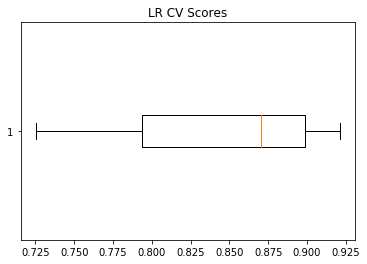

In [81]:
plt.boxplot(test_scores, vert=False)
plt.title('LR CV Scores');

In [92]:
# best features
lr.coef_

array([[-1.60517873, -0.24853599,  0.32795846,  0.27848312,  0.17031778,
        -0.32727564,  0.35882366]])

**Results:**
- The LR model performs at about 85% accuracy on both the training and test sets.
- There is more variability with a 10-fold cross-validation. Accuracy ranges from 73-92%, and is 84% on average.
- This model is slightly better at predicting schools where median debt is on the low-end.
- It is relying heavily on the certificate/associate flag. The cities/large suburbs flag is least important.

## KNN

In [93]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [94]:
test_score = knn.score(X_test, y_test)
train_score = knn.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8769104803493449
Score on test data:  0.8526315789473684


This model predicted correctly for about 88% of the training data and 85% of the test data. It is overfitting a bit, and accuracy is not much improved from the logistic regression model above. I'll try decreasing and increasing the number of neighbors.

In [95]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [96]:
test_score2 = knn2.score(X_test, y_test)
train_score2 = knn2.score(X_train, y_train)

print('Score on training data: ', train_score2)
print('Score on test data: ', test_score2)

Score on training data:  0.8883733624454149
Score on test data:  0.8138504155124654


With 2 neighbors, overfitting is much worse.

In [97]:
knn3 = KNeighborsClassifier(n_neighbors=10)
knn3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [98]:
test_score3 = knn3.score(X_test, y_test)
train_score3 = knn3.score(X_train, y_train)

print('Score on training data: ', train_score3)
print('Score on test data: ', test_score3)

Score on training data:  0.8668122270742358
Score on test data:  0.843213296398892


With 10 neighbors, overfitting improved slightly.

In [107]:
predictions_knn = knn3.predict(X_test)
confusion_knn = confusion_matrix(y_test, predictions_knn, labels=[1, 0])
print(confusion_knn)

[[665 188]
 [ 95 857]]


In [100]:
report_knn = classification_report(y_test, predictions_knn, target_names=['Low Debt','High Debt'])
print(report_knn)

              precision    recall  f1-score   support

    Low Debt       0.82      0.90      0.86       952
   High Debt       0.88      0.78      0.82       853

    accuracy                           0.84      1805
   macro avg       0.85      0.84      0.84      1805
weighted avg       0.85      0.84      0.84      1805



In [101]:
knn_test_scores = cross_val_score(knn3, X, y, cv=10, scoring='accuracy')
print(knn_test_scores)

[0.91407678 0.90127971 0.90127971 0.8702011  0.83363803 0.90493601
 0.89579525 0.7678245  0.77696527 0.64652015]


In [102]:
knn_test_scores.mean()

0.8412516490213017

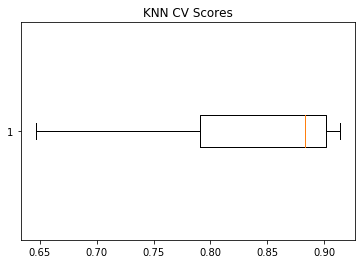

In [103]:
plt.boxplot(knn_test_scores, vert=False)
plt.title('KNN CV Scores');

**Results:**
- With 10 neighbors, KNN is about 87% accurate on the training set and 84% on test data.
- Scores on sets in a 10-fold cv ranged from 65-91%, with average of 84%.
- The model seems to favor 'low debt' instances where recall is higher, but precision is lower.
- KNN is about as accurate as the logistic regression model above, but is more prone to overfitting and variable accuracy among sample sets.

## Random Forest

In [111]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
test_score_rfc = rfc.score(X_test, y_test)
train_score_rfc = rfc.score(X_train, y_train)

print('Score on training data: ', train_score_rfc)
print('Score on test data: ', test_score_rfc)

Score on training data:  0.9443231441048034
Score on test data:  0.8421052631578947


In [106]:
predictions_rfc = rfc.predict(X_test)
confusion_rfc = confusion_matrix(y_test, predictions_rfc, labels=[1, 0])
print(confusion_rfc)

[[693 160]
 [129 823]]


In [42]:
report_rfc = classification_report(y_test, predictions_rfc, target_names=['Low Debt','High Debt'])
print(report_rfc)

              precision    recall  f1-score   support

    Low Debt       0.84      0.86      0.85       952
   High Debt       0.84      0.81      0.83       853

    accuracy                           0.84      1805
   macro avg       0.84      0.84      0.84      1805
weighted avg       0.84      0.84      0.84      1805



In [115]:
rfc_test_scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
print(rfc_test_scores)

[0.89396709 0.88299817 0.89213894 0.85374771 0.80804388 0.89579525
 0.87202925 0.75502742 0.76965265 0.6959707 ]


In [116]:
rfc_test_scores.mean()

0.8319371061601408

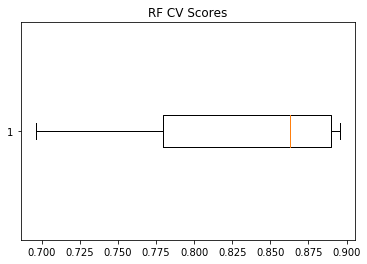

In [117]:
plt.boxplot(rfc_test_scores, vert=False)
plt.title('RF CV Scores');

In [119]:
importances = rfc.feature_importances_
print(importances)

[0.2596561  0.03755115 0.0746705  0.02047712 0.01524173 0.23693973
 0.35546368]


**Results:**
- The RF model overfits and performs with about 10% more accuracy on training data. 
- However, the range in accuracy across a 10-fold cv is similar to the LR model above, 70-90%. The average across all folds is 83%, slightly lower.
- The model has equal precision on both categories and higher recall on 'low debt' instances.
- The RF model relies mostly on average faculty salary, followed by the certificate/associate highest degree flag and the percentage of part-time undergrads. Again, the cities/large suburbs flag is least important.

# Conclusions
Predicting which schools have higher median student debt may be useful to stakeholders and NGOs working on higher education and financial policies, professionals interested in starting colleges, and the companies that offer student loans. 

The College Scorecard dataset is a great public resource, with a variety of datapoints. In the future, it may be useful to combine this information with other sources, perhaps relating to leadership and scholarships offered at various schools. 

Based on my analysis above, I would recommend continuing to find and engineer features to improve the Random Forest model. While my RF model overfit on training data and was slightly less accurate than my other models; it was equally precise on 'low debt' and 'high debt' instances and similar in range of accuracy across a 10-fold cross-validation. Compared to my Logistic Regression, RF was also more democratic in assigning feature importances.  

In future research, it would be interesting to explore median student debt or a similar statistic *per program* per school. Both the LR and RF models I explored relied on the variable 'HIGHDEG' which indicates the highest degree an institution awards. Of course, we expect that in most cases it will be cheaper and less time-consuming to get a certificate than a higher degree. Among the schools where median student debt is below average, which are actually more generous in offering scholarships?